# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import re
import math
import functools
import itertools
import traceback
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import marsilea as ma
import marsilea.plotter as mp
import anndata
from anndata import AnnData
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import corescpy as cr

# Main
read_full_obj = False  # must be True to plot spatial; False = faster

# Process Options
panel = "TUQ97N"  # Xenium panel ID
col_cell_type = "leiden_res1pt5_dist0_npc30"
layer_log1p = "log1p"
col_ann = "bucket"
regions = ["mucosa", "submucosa", "myenteric_plexus",
           "smc_circular", "smc_longitudinal", "serosa"]
palette = {"inflamed": "red", "uninflamed": "blue", "stricture": "yellow"}
# genes_dict = {
#     "CD Risk": ["LACC1", "LRRK2", "PTGER4"],
#     "SnC Marker": ["CDKN2A", "CDKN1A", "TP53", "PLAUR"],
#     "Apoptosis-Resistance": ["BCL2"],
#     "SASP": ["IL4", "IL13", "IL1A", "CXCL8", "CCL2", "CEBPB", "NFKB1",
#              "TGFB1", "IGFBP7"],
#     "SASP-IL6": ["OSM", "IL6", "IL6ST"],
#     "Fibrosis": ["SUCNR1", "CXCR4", "IL33", "IL23A",
#                  "IL1B", "IL12", "IL17", "IL36", "TL1A", "IL11", "IFNG",
#                  "IL22", "IL10", "IL21", "IL34", "CCL11"],
#     "ER Stress/UPR": ["ATF4"],
#     "Autophagy": ["MTOR", "ATG3", "ATG5", "ATG7", "ATG12", "ATG16L1",
#                   "SQSTM1", "BECN1", "IRGM1", "ATG8", "ATG6"],
#     "DNA Repair": ["ERCC1", "ERCC4"],
#     "Healing": ["LCN2", "MMP9", "GREM1", "PDGFRA"],
#     "Mixed": ["ICAM1"]
# }
genes_dict = {
    "TH1": ["CD3D", "CD3E", "IFNG", "IFNGR2", "STAT4", "TBX21", "CD4"],
    "TH2": ["CD14", "CXCR4", "IL4", "STAT5A", "STAT5B", "IL10", "IL13"],
    "TH17/Treg": ["CCL20", "IL21", "IL22", "IL23R", "RORC", "TGFB1", "STAT3"]
}
# gene_combos = [["IL6", "IL6ST"], ["PLAUR", "PLAU"], ["CDKN1A", "TP53"]]
gene_combos = [genes_dict[x] for x in genes_dict]
# genes_cat_colors = None
# genes_dict_colors = ["#FF0000", "#0000FF", "#000000", "#FFFF00", "#D2B48C",
#                      "#FFC0CB", "#A52A2A", "#800080", "#008000", "#808080"]
genes_dict_colors = ["#FF0000", "#0000FF", "#000000", "#FFFF00", "#D2B48C",
                     "#FFC0CB", "#A52A2A", "#800080", "#008000", "#808080"]
genes = list(pd.unique(functools.reduce(lambda u, v: u + v, [
    genes_dict[x] for x in genes_dict])))
# palette = "tab20"
n_combos = [1, 2, 3, 4]
# libs = [  # sample IDs from patients for whom we have all conditions
#     "50452A", "50452B", "50452C",  # old segmentation
#     "50006A", "50006B", "50006C",  # rest are new segmentation
#     "50217A", "50217B", "50217C",
#     "50336B", "50336C", "50336A",
#     "50403A2", "50403B", "50403C1"
# ]  # excludes low-quality sample/condition replicates 50403A1 & 50403C2
libs = ["50006A", "50006B", "50217A", "50217B", "50336B", "50336C",
        "50403B", "50403A2"]  # just inflamed/uninflamed (no strictures)
# libs = None  # to run all available samples
input_suffix = ""  # in case want to crop objects with some suffix
# due to creation of a subsidiary object, e.g., for
# "Stricture-50452C_downsampled.h5ad"
# input_suffix would be "_downsampled". For "main" objects, input_suffix=""
plot = True  # could slow process down if large samples/cropped area
layer = "counts"

# Files & Directories
direc = "/mnt/cho_lab/bbdata2/"  # mounted NFS with data
dir_entry = "/mnt/cho_lab/disk2"  # Spark writeable data directory
mdf = str("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/"
          f"samples_{panel}.csv")  # metadata file path
dir_writeable = os.path.join(
    dir_entry, f"elizabeth/data/shared-xenium-library")  # where objects are
out_dir = os.path.join(
    dir_writeable, f"outputs/{panel}/nebraska")  # object output directory
out_new = out_dir
# out_new = ?  # specify cropped objects output directory
out_sub = os.path.join(out_new, "objects_cropped")  # cropped objects

# Constants (Shouldn't Need Edits Unless Extreme Process Changes)
constants_dict = cr.get_panel_constants(panel)
cso, col_sample, col_condition, col_inflamed, col_subject = [
    constants_dict[x] if x in constants_dict else None for x in [
        "col_sample_id_o", "col_sample_id", "col_condition",
        "col_inflamed", "col_subject"]]
col_stricture, key_stricture, col_f, col_tangram, col_segment, col_object = [
    constants_dict[x] if (x in constants_dict) else None for x in [
        "col_stricture", "key_stricture", "col_data_dir",
        "col_tangram", "col_segment", "col_object"]]
show_cols = [col_subject]  # only change if not TUQ97N
dir_data = os.path.join(direc, f"outputs/{panel}")
files = functools.reduce(lambda i, j: i + j, [[os.path.join(
    run, i) for i in os.listdir(os.path.join(
        dir_data, run))] for run in os.listdir(dir_data)])  # all data paths
metadata = cr.pp.get_metadata_cho(direc, mdf, panel_id=panel, samples=libs)

# Annotations
f_ann = pd.read_excel(os.path.join(
    out_dir, "annotation_dictionaries/annotations_all.xlsx"), index_col=[
        0, 1]).dropna(how="all").dropna(how="all", axis=1)
f_ann = f_ann.reset_index().astype({f_ann.index.names[1]: "int"}).astype({
    f_ann.index.names[1]: "string"}).set_index(f_ann.index.names)
metadata[show_cols]

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

,subject_id
Sample,
Inflamed-50006A,50006
Uninflamed-50006B,50006
Inflamed-50217A,50217
Uninflamed-50217B,50217
Inflamed-50336B,50336
Uninflamed-50336C,50336
Inflamed-50403B,50403
Uninflamed-50403A2,50403


# Regions Plots



mucosa




submucosa




myenteric_plexus




smc_circular




smc_longitudinal




FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/smc_longitudinal/Inflamed-50217A_smc_longitudinal.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

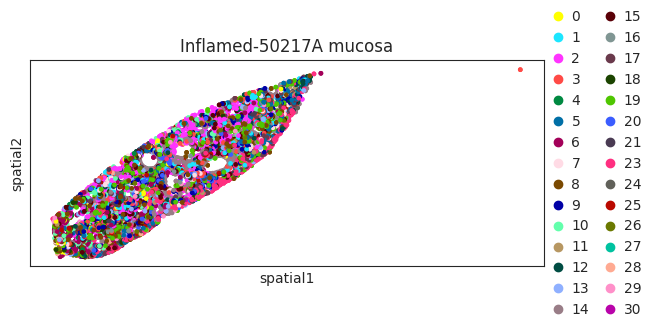

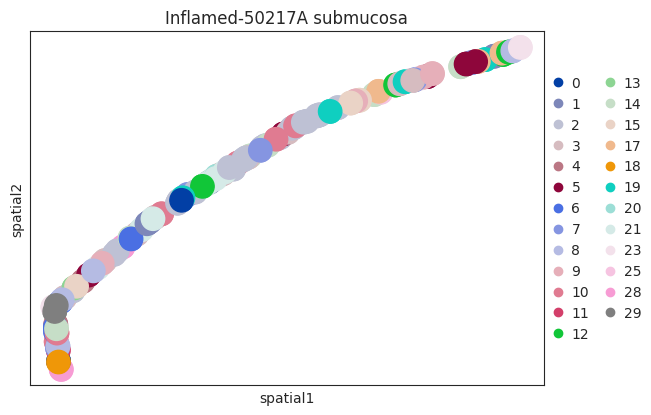

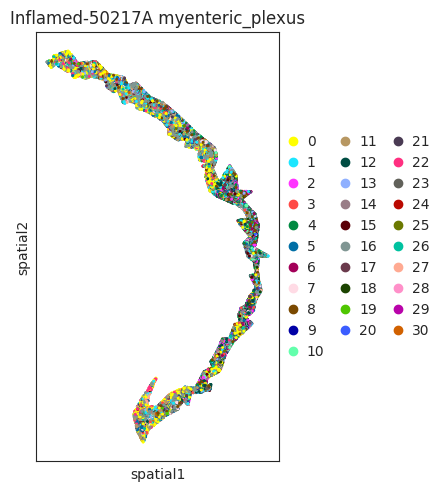

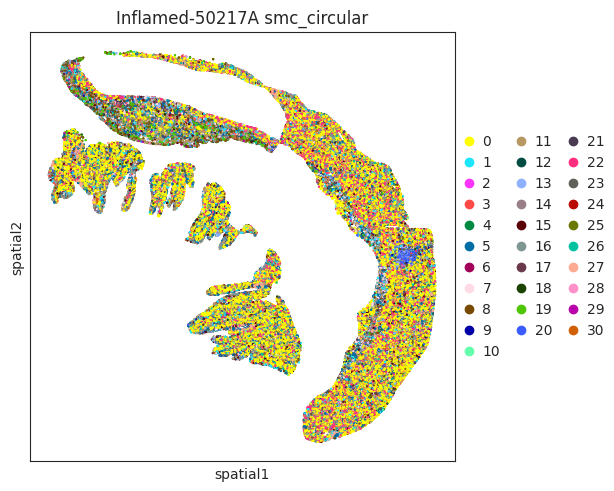

In [2]:
for r in regions:
    print(f"\n\n{'=' * 80}\n{r}\n{'=' * 80}\n\n")
    res, cox = {}, {}
    for s in ["Inflamed-50217A"]:
        if not os.path.exists(os.path.join(out_sub, r, f"{s}_{r}.h5ad")):
            print(f"{out_sub}/{s}_{r}.h5ad doesn't exist!")
            plt.figure()
            continue
        adata = sc.read_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))
        sq.pl.spatial_scatter(
            adata, library_id="spatial", title=f"{s} {r}",
            shape=None, color=["leiden_res1pt5_dist0_npc30"], wspace=0.4)

# Cells

In [2]:
%%time

results, coexp = {}, {}
for r in regions:
    print(f"\n\n{'=' * 80}\n{r}\n{'=' * 80}\n\n")
    res, cox = {}, {}
    for s in metadata.index:
        print(f"\n\n\t{'*' * 40}\n\t{s}\n\t{'*' * 40}\n\n")
        if not os.path.exists(os.path.join(out_sub, r, f"{s}_{r}.h5ad")):
            print(os.path.join(out_sub, f"{r}/{s}_{r}.h5ad") + " not found")
            continue
        adata = sc.read_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))
        res[s] = cr.ax.classify_gex_cells(
            adata, col_cell_type=col_cell_type, genes=list(set(
                genes).intersection(adata.var_names)))  # count + cells
        cox[s] = cr.ax.classify_coex_cells(
            adata, col_cell_type=col_cell_type, genes=[list(set(
                g).intersection(adata.var_names)) for g in gene_combos])
    results[r] = pd.concat(res, names=[col_sample])
    coexp[r] = pd.concat(cox, names=[col_sample])
results = pd.concat(results, names=["Region"]).join(metadata[[
    col_subject, col_condition]]).set_index([
        col_subject, col_condition], append=True).reset_index(
            col_sample).rename({"Percent": "Percent_Positive"}, axis=1)
coexp = pd.concat(coexp, names=["Region"]).join(metadata[[
    col_subject, col_condition]]).set_index([
        col_subject, col_condition], append=True).reset_index(
            col_sample).rename({"Percent": "Percent_Positive"}, axis=1)



mucosa




	****************************************
	Inflamed-50006A
	****************************************




	****************************************
	Uninflamed-50006B
	****************************************




	****************************************
	Inflamed-50217A
	****************************************




	****************************************
	Uninflamed-50217B
	****************************************




	****************************************
	Inflamed-50336B
	****************************************




	****************************************
	Uninflamed-50336C
	****************************************




	****************************************
	Inflamed-50403B
	****************************************




	****************************************
	Uninflamed-50403A2
	****************************************




submucosa




	****************************************
	Inflamed-50006A
	****************************************




	******************

In [15]:
suff = "_".join(regions) + "__" + "_".join(genes)
files_res = [os.path.join(out_dir, "quantification",
                          f"n_cells_positive_{suff}.csv"), os.path.join(
                              out_dir, "quantification",
                              f"n_cells_coex_positive_{suff}.csv")]
print(files_res)
results.to_csv(files_res[0])
coexp.to_csv(files_res[1])

['/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/quantification/n_cells_positive_mucosa_submucosa_myenteric_plexus_smc_circular_smc_longitudinal_serosa__CD3D_CD3E_IFNG_IFNGR2_STAT4_TBX21_CD4_CD14_CXCR4_IL4_STAT5A_STAT5B_IL10_IL13_CCL2O_IL21_IL22_IL23R_RORC_TGFB1_STAT3.csv', '/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/quantification/n_cells_coex_positive_mucosa_submucosa_myenteric_plexus_smc_circular_smc_longitudinal_serosa__CD3D_CD3E_IFNG_IFNGR2_STAT4_TBX21_CD4_CD14_CXCR4_IL4_STAT5A_STAT5B_IL10_IL13_CCL2O_IL21_IL22_IL23R_RORC_TGFB1_STAT3.csv']


# Transcripts

In [ ]:
%%time

txs_cl, genes = {}, None
for r in regions:
    print(f"\n\n{'=' * 80}\n{r}\n{'=' * 80}\n\n")
    clus = {}
    for s in metadata.index:
        print(f"\n\n\t{'*' * 40}\n\t{s}\n\t{'*' * 40}\n\n")
        if not os.path.exists(os.path.join(out_sub, r, f"{s}_{r}.h5ad")):
            print(os.path.join(out_sub, f"{r}/{s}_{r}.h5ad") + " not found")
            continue
        adata = sc.read_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))
        adata.X = adata.layers[layer].copy()
        clus[s] = cr.ax.classify_tx(
            adata, genes=genes, col_cell_type=col_cell_type)  # count + cells
    txs_cl[r] = pd.concat(clus, names=[col_sample])
txs_cl = pd.concat(txs_cl, names=["Region"])
txs_cl = txs_cl.join(metadata[[col_subject, col_condition]]).set_index([
    col_subject, col_condition], append=True).reset_index(col_sample)
txs_cl

In [ ]:
# suff = "_".join(regions) if genes is None else "_".join(
#     regions) + "__" + "_".join(genes)
# txs_cl.to_excel(os.path.join(out_dir, "quantification",
#                              f"n_transcripts_{suff}.xlsx"))

# Reload Prior Results

In [ ]:
suf = "_".join(regions) + "__" + "_".join(genes)
results = pd.read_excel(
    os.path.join(out_dir, f"quantification/n_cells_positive_{suf}.xlsx"),
    index_col=[0, 1, 2, 3, 4])
ixs = results.index.names
results = results.reset_index()
results.loc[:, col_cell_type] = results[col_cell_type].astype(
    int).astype("string")
results = results.set_index(ixs)
coexp = pd.read_excel(
    os.path.join(
        out_dir, f"quantification/n_cells_coex_positive_{suf}.xlsx"),
    index_col=[0, 1, 2, 3, 4])
coexp = coexp.reset_index().astype({col_cell_type: "string"}).set_index(
    coexp.index.names)
coexp = coexp.reset_index()
coexp.loc[:, col_cell_type] = coexp[col_cell_type].astype(
    int).astype("string")
coexp = coexp.set_index(ixs)
coexp

# Inspect

In [ ]:
for i, x in enumerate([results, coexp]):
    print(f"\n\n{'=' * 80}\n{['Expression', 'Coexpression'][i]}\n{'=' * 80}")
    x.dropna().groupby("Region").apply(lambda x: print(x.name, len(
        x.Sample.unique()), "\n\t", ", ".join(x.Sample.unique())))

In [ ]:
results

In [ ]:
coexp

# Checks

In [ ]:
for r in regions:
    print(f"\n\n{'=' * 80}\n{r}\n{'=' * 80}\n\n")
    for s in metadata.index:
        print(f"\n\n\t{'*' * 40}\n\t{s}\n\t{'*' * 40}\n\n")

        # Data & QC
        adata = sc.read_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))
        adata.X = adata.layers[layer].copy()
        qcs, qgs = sc.pp.calculate_qc_metrics(
            adata, inplace=False, layer="counts", percent_top=None)  # QC

        # Sample Ns
        res = results.loc[r].loc[:, :, metadata.loc[s][col_subject],
                                metadata.loc[s][col_condition], :]
        assert all(res["N_Sample"] == adata.obs.shape[0])

        # Cluster Ns
        n_clus_comp = adata.obs[col_cell_type].value_counts().to_frame(
            "N_C").join(res.loc[res.reset_index().Gene[0]][["N_Cluster"]])
        assert n_clus_comp["N_Cluster"].astype(float).compare(
            n_clus_comp.N_C.astype(float)).empty

        # Cluster N Sums = Scanpy-Calculated
        for g in res.reset_index().Gene.unique():
            if res.loc[g].iloc[0]["threshold"] == 0:
                assert qgs.loc[g]["n_cells_by_counts"] == res.loc[g][
                    "N_Cells_Positive"].sum()
                print(f"N + Cells = Scanpy calculation for {s}/{g}.")
            else:
                print(f"Threshold != 0; can't compare to Scanpy for {s}/{g}.")

        # Cluster Ns (Individual)
        for x in adata.obs[col_cell_type].unique():
            assert res.loc[g].loc[x]["N_Cells_Positive"] == sum([
                i[0] > res.loc[g].loc[x]["threshold"]
                for i in adata[adata.obs[col_cell_type] == x, g].X.toarray()])
        print(f"N + Cells = manual re-calculation {s}/{g}.")

        sc.pp.calculate_qc_metrics(adata, percent_top=None, layer=layer)
        adata.write_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))

# Visualization

In [ ]:
def pass_fx():
    """Pass."""
    pass

In [ ]:
# size = agg_count / agg_cell_counts[:, np.newaxis]
# m = ma.SizedHeatmap(
#     size=size,
#     color=agg_exp,
#     cluster_data=size,
#     height=h / 3,
#     width=w / 3,
#     edgecolor="lightgray",
#     cmap="Blues",
#     size_legend_kws=dict(
#         colors="#538bbf",
#         title="Fraction of cells\nin groups (%)",
#         labels=["20%", "40%", "60%", "80%", "100%"],
#         show_at=[0.2, 0.4, 0.6, 0.8, 1.0],
#     ),
#     color_legend_kws=dict(title="Mean expression\nin group"),
# )

# m.add_top(mp.Labels(markers), pad=0.1)
# m.add_top(mp.Chunk(uni_cells, fill_colors=cell_colors, rotation=90))
# m.group_cols(cells, order=uni_cells)

# m.add_right(mp.Labels(agg.obs["louvain"], align="center"), pad=0.1)
# m.add_left(
#     mp.Numbers(agg_cell_counts, color="#EEB76B", label="Count"), size=0.5, pad=0.1
# )
# m.add_dendrogram("right", pad=0.1)
# m.add_legends()
# m.render()

## Annotations

In [27]:
anns = pd.concat([f_ann.loc[f"{s}___{col_cell_type}_dictionary.xlsx"][
    col_ann] for s in metadata.index],
                 keys=metadata.index, names=[col_sample, col_cell_type])
results_ann = results.groupby([col_sample, col_cell_type]).apply(
    lambda x: x.assign(Annotation=anns.loc[x.name[0]].loc[
        x.name[1]])).sort_index()
coexp_ann = coexp.groupby([col_sample, col_cell_type]).apply(
    lambda x: x.assign(Annotation=anns.loc[x.name[0]].loc[
        x.name[1]])).sort_index()

ann_ns = results_ann.set_index("Annotation", append=True)[[
    "N_Cluster", "N_Cells_Positive"]].apply(lambda y: y.groupby(
        list(results_ann.index.names.difference(set([col_cell_type]))) + [
            "Annotation"]).sum()).reset_index([col_subject, col_condition])
ann_ns = ann_ns.join(results_ann["N_Sample"].groupby(list(set(
    results_ann.index.names).difference(set([col_cell_type])))).apply(
        lambda x: x.iloc[0]))
ann_ns = ann_ns.assign(Percent_Composition=100 * ann_ns[
    "N_Cluster"] / ann_ns["N_Sample"])
ann_ns = ann_ns.assign(Percent_Positive=100 * ann_ns[
    "N_Cells_Positive"] / ann_ns["N_Cluster"])
ann_ns = ann_ns.drop(ann_ns.columns.intersection(ann_ns.index.names), axis=1)
assert all(round(ann_ns["Percent_Composition"].groupby(list(
    ann_ns.index.names.difference(set(["Annotation"])))).sum()) == 100)
assert all(round(ann_ns["Percent_Composition"].groupby(list(
    ann_ns.index.names.difference(set(["Annotation"])))).sum()) == 100)

## Gene-Positive Cell Percentages

In [28]:
# col_plot = "leiden_res1pt5_dist0_npc30"
# d_plot = results

col_plot = "Annotation"
d_plot = ann_ns

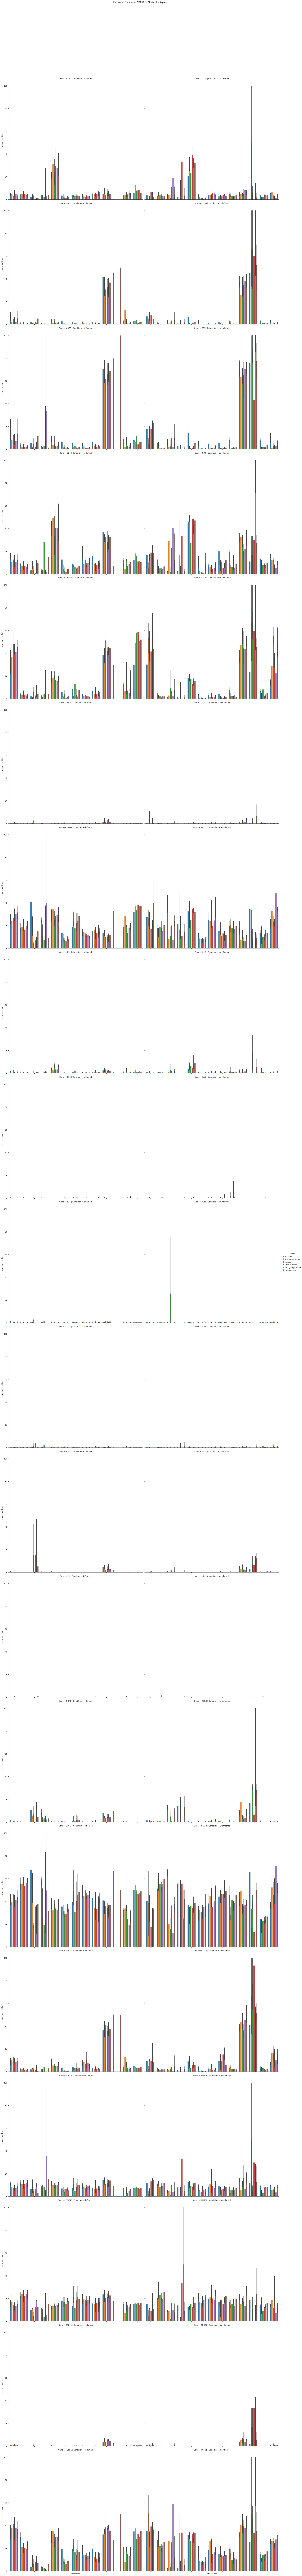

In [32]:
fig = sb.catplot(d_plot.reset_index(), hue="Region",
                 x=col_plot, y="Percent_Positive",
                 row="Gene", col=col_condition, kind="bar", height=10)
fig.fig.suptitle(f"Percent of Cells + for {g} in Cluster by Region")
fig.set_xticklabels(rotation=45)
fig.fig.tight_layout()
fig.legend.set_bbox_to_anchor((1, 0.5))
fig.legend.set_loc("center left")
plt.subplots_adjust(top=0.95)

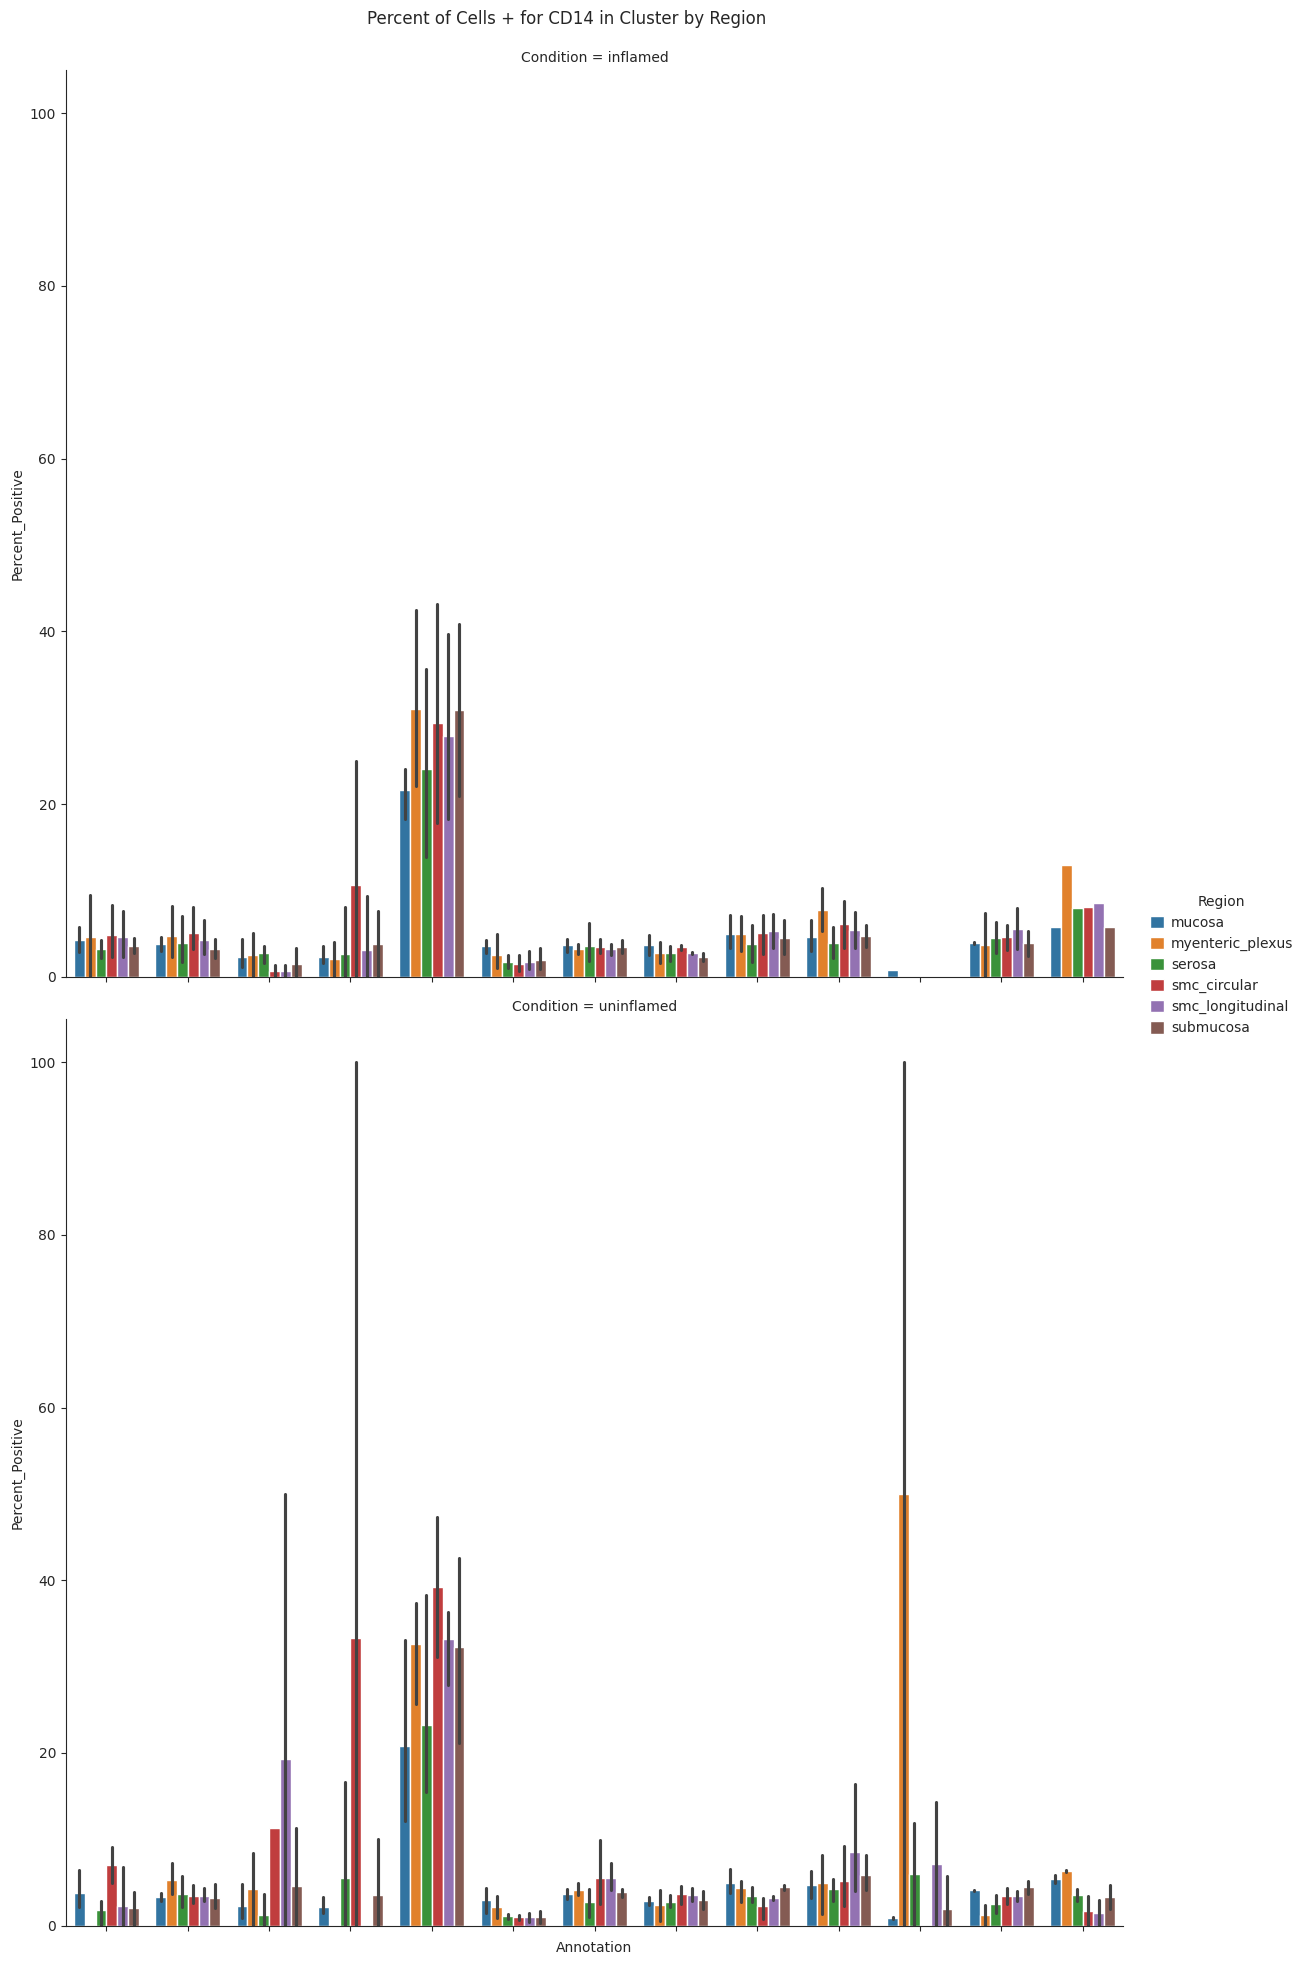

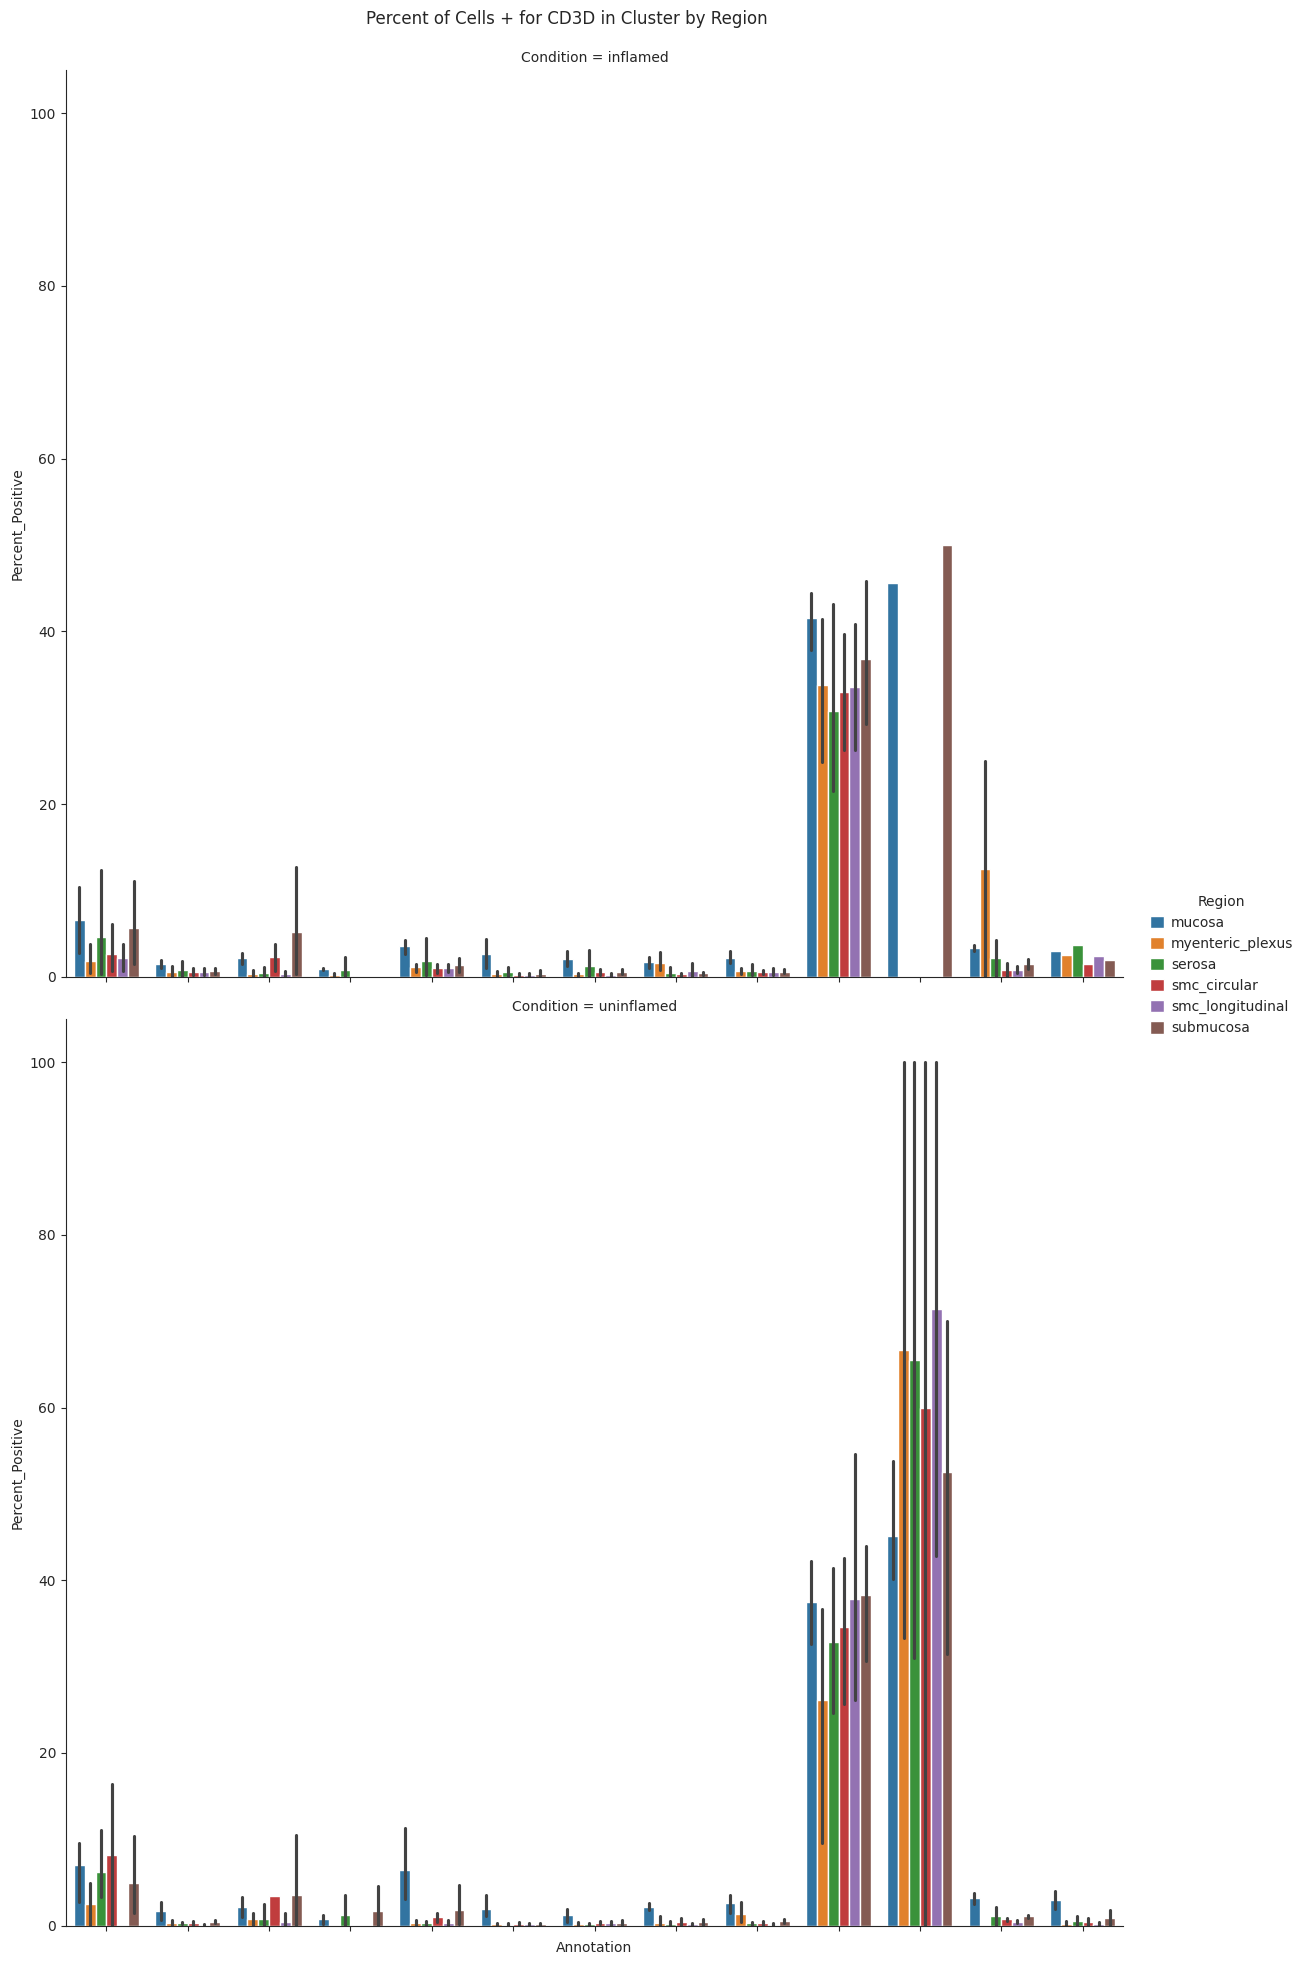

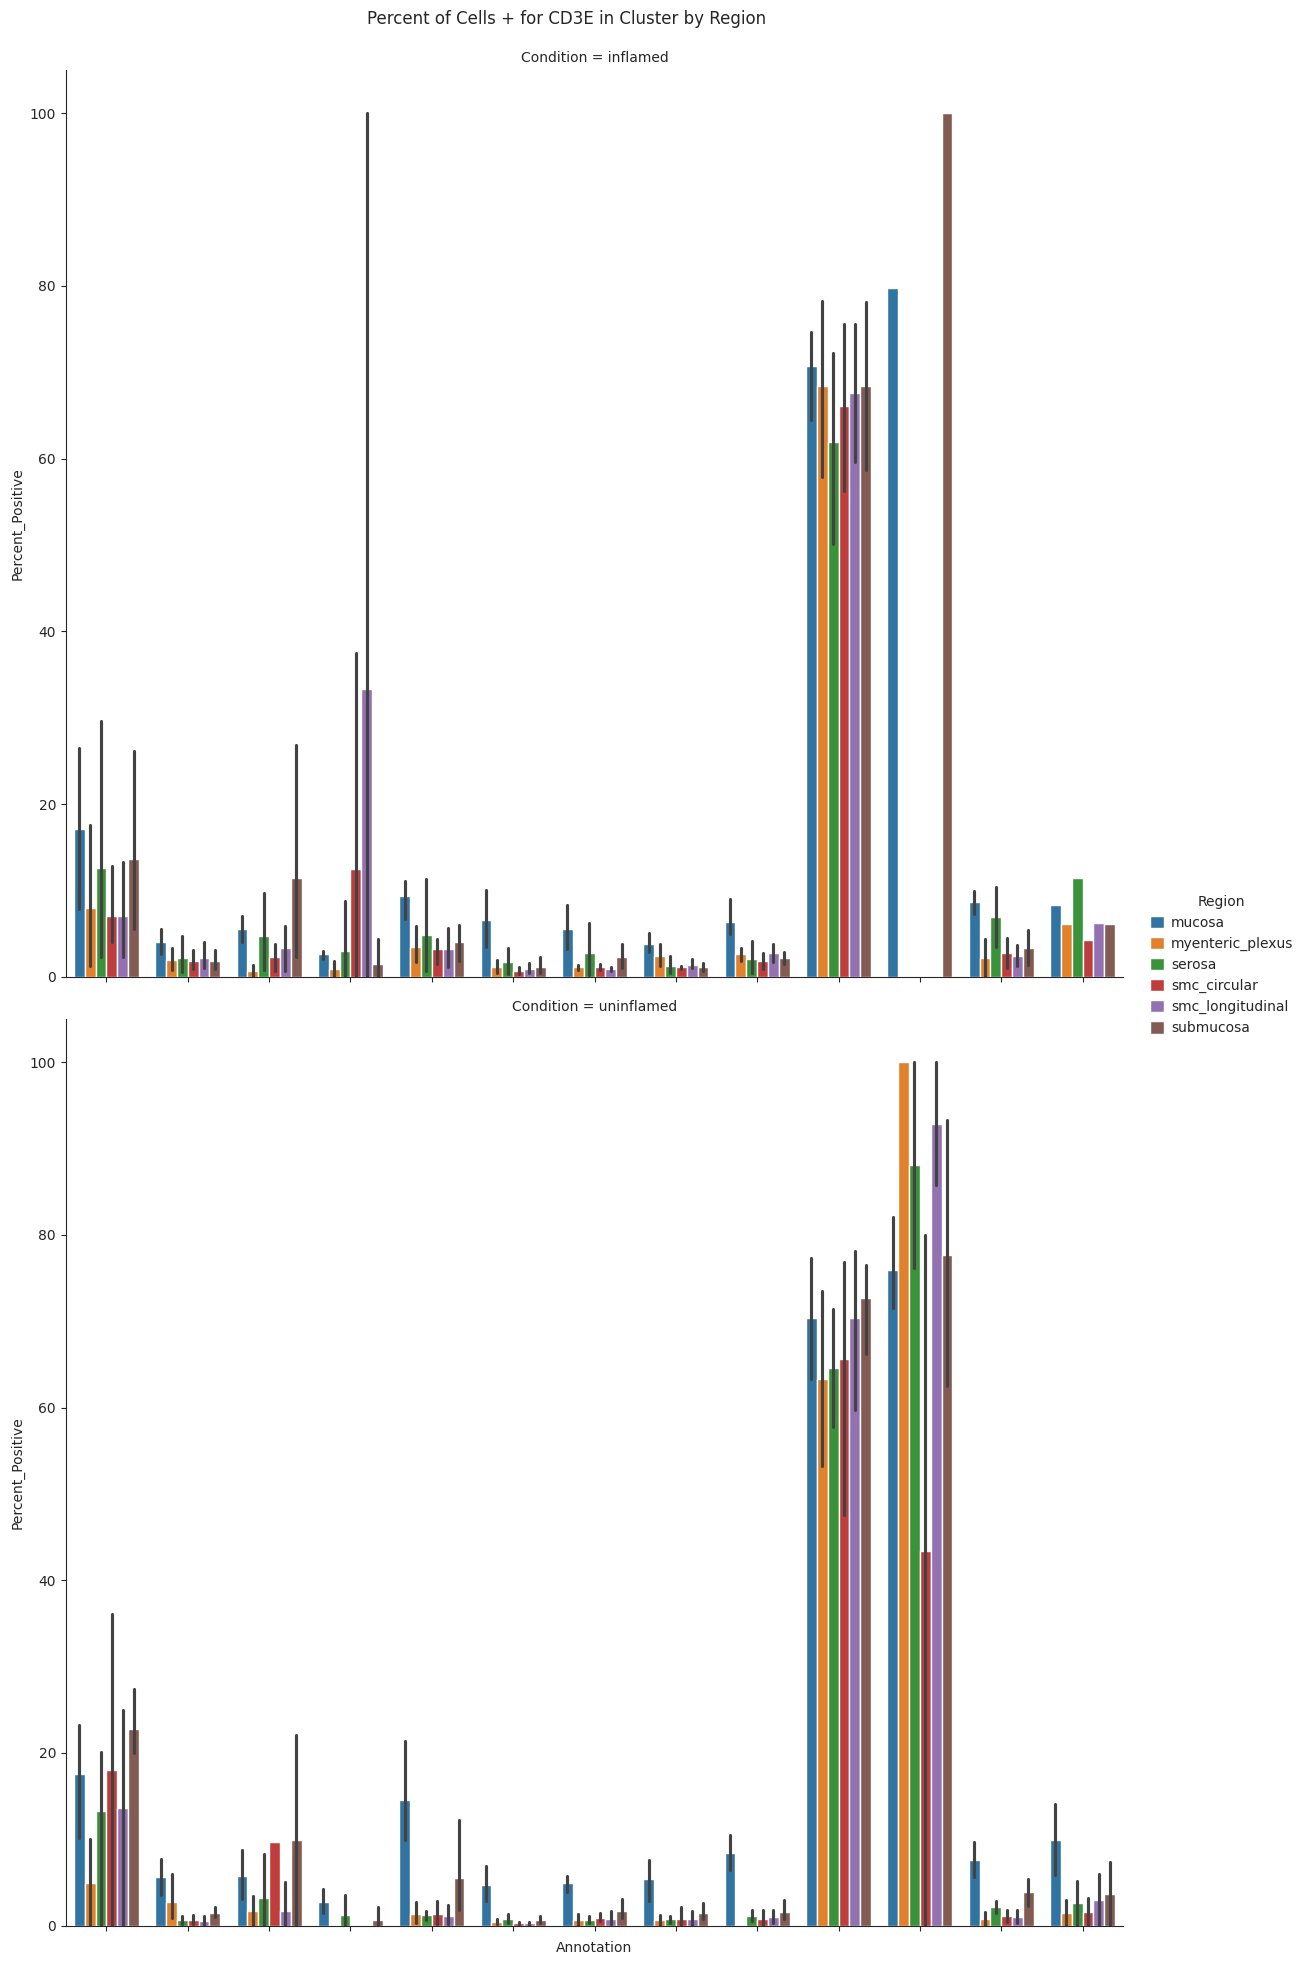

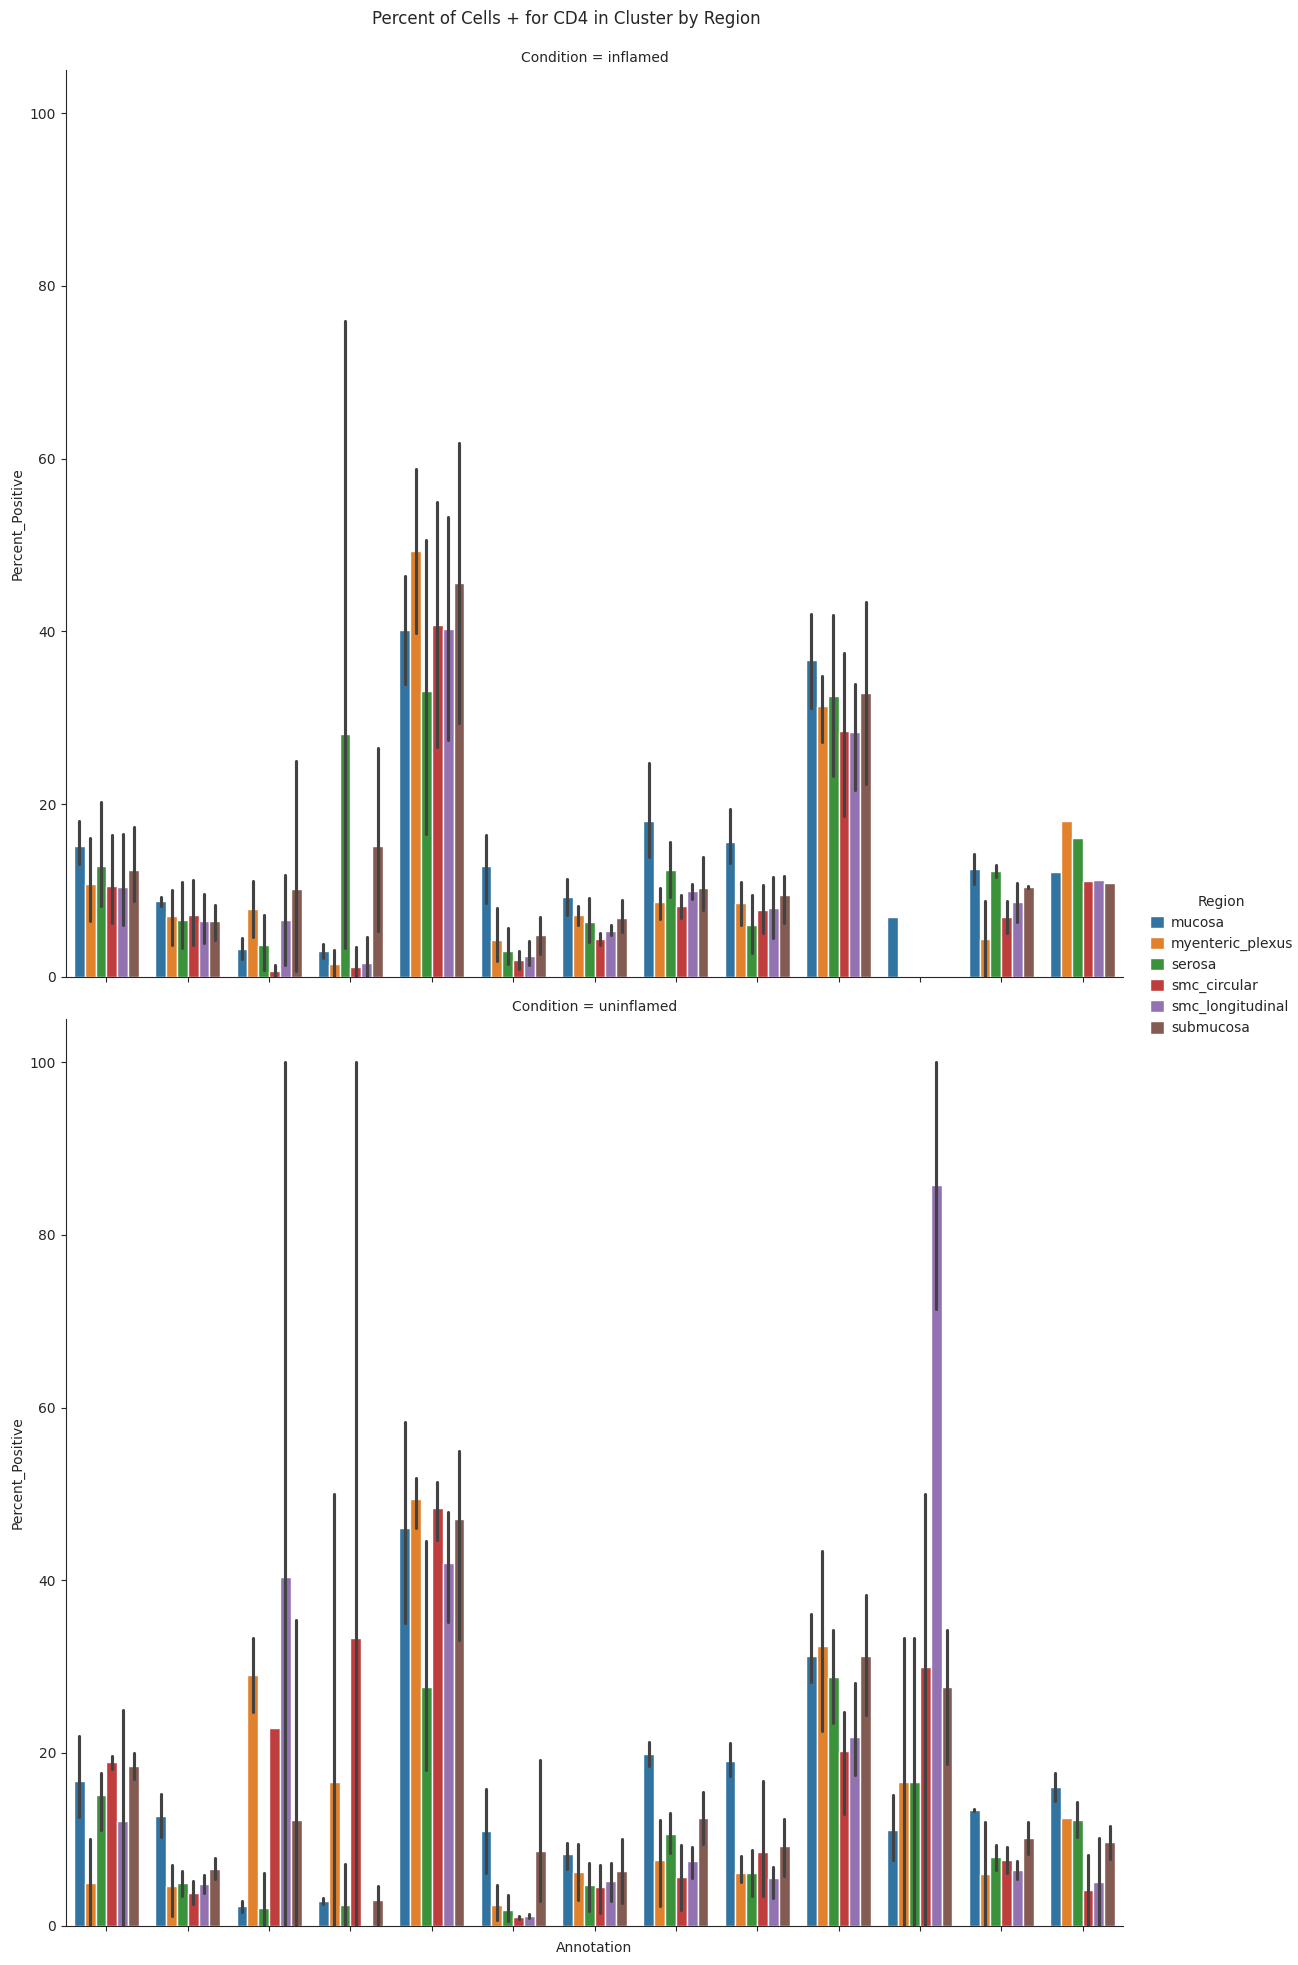

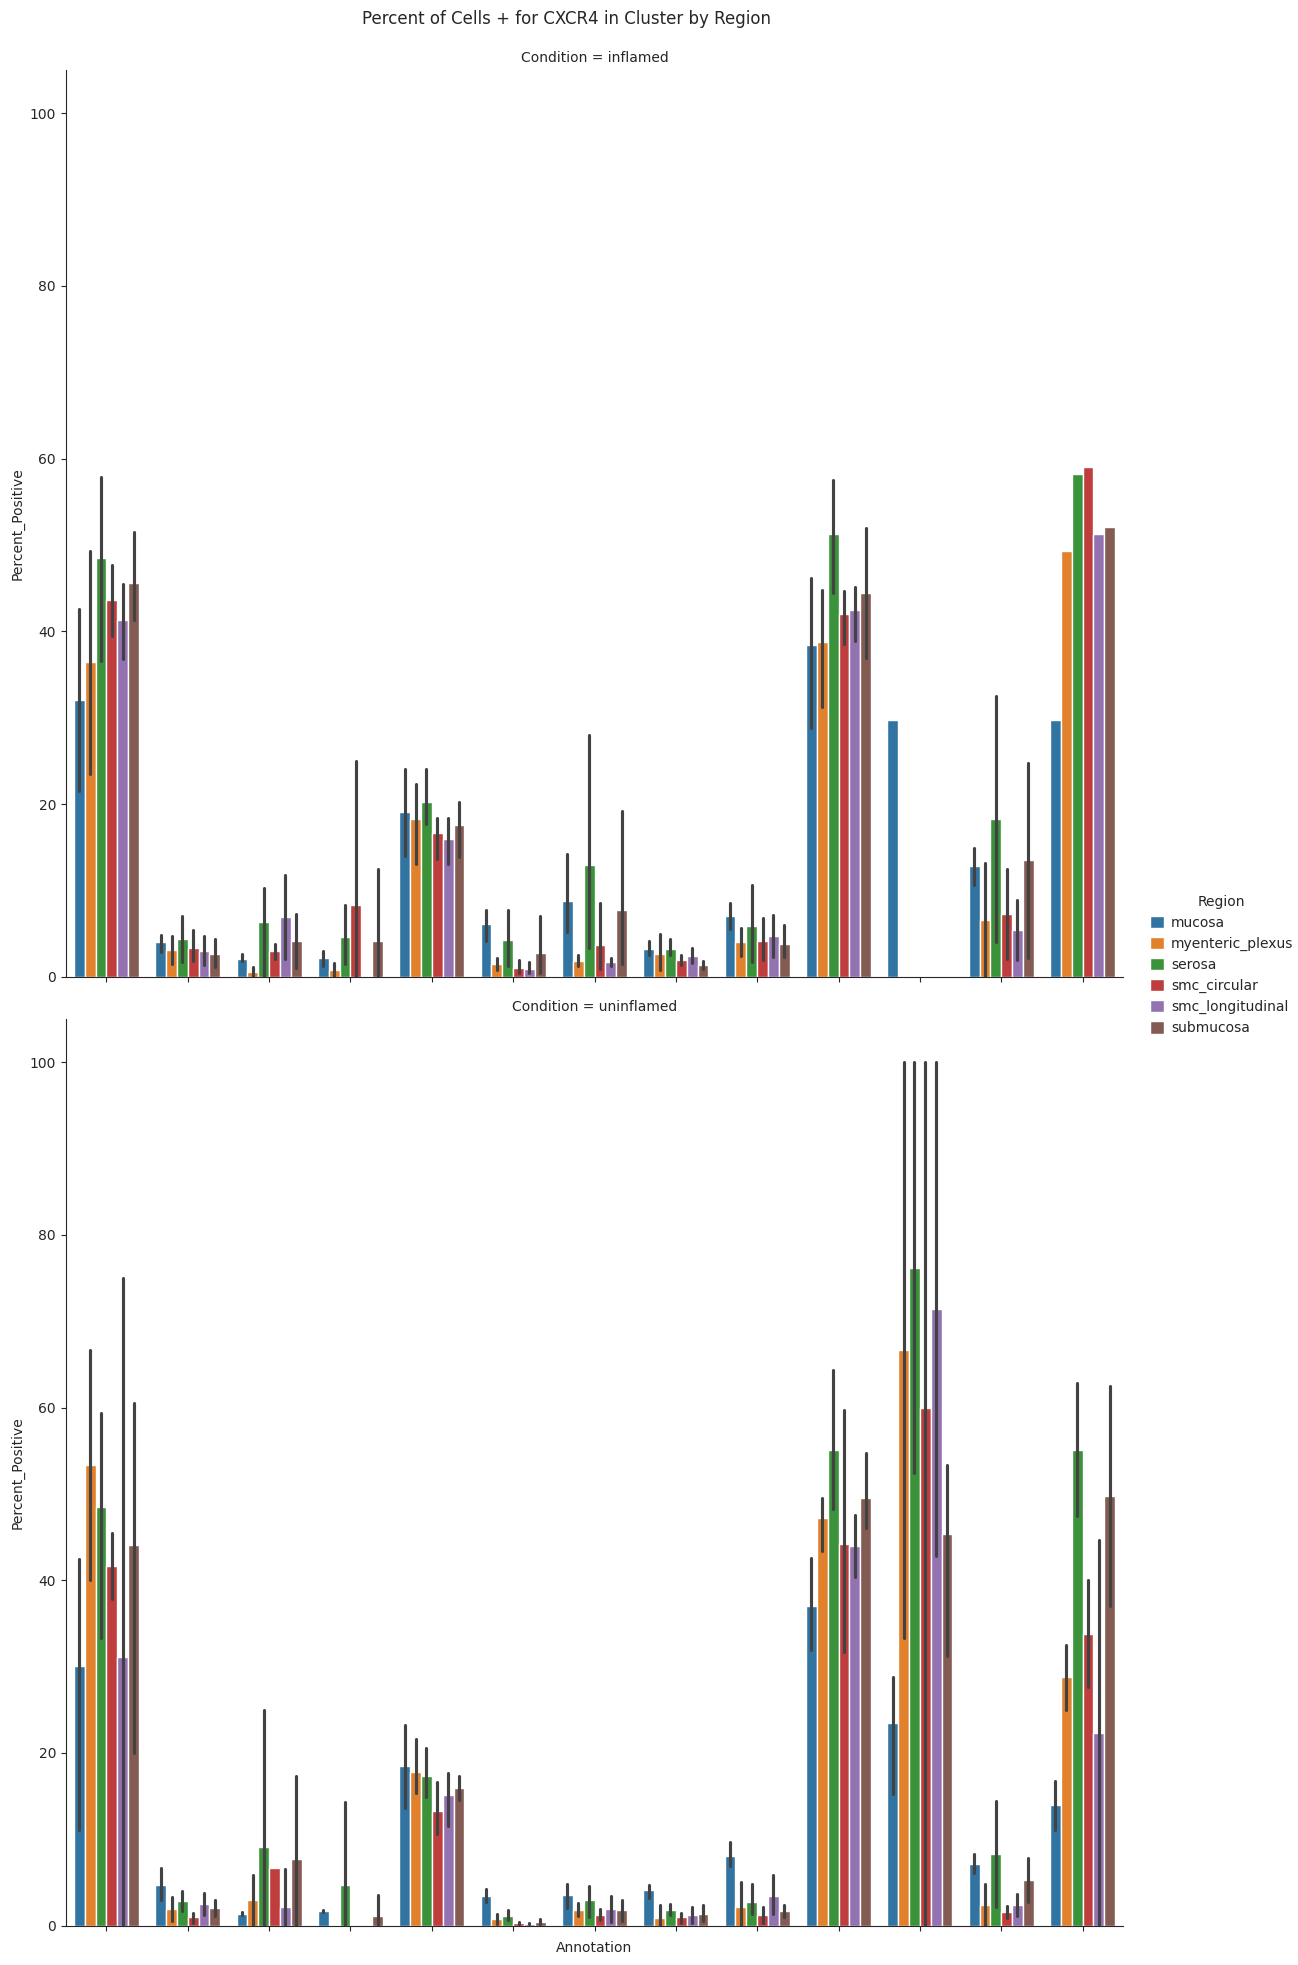

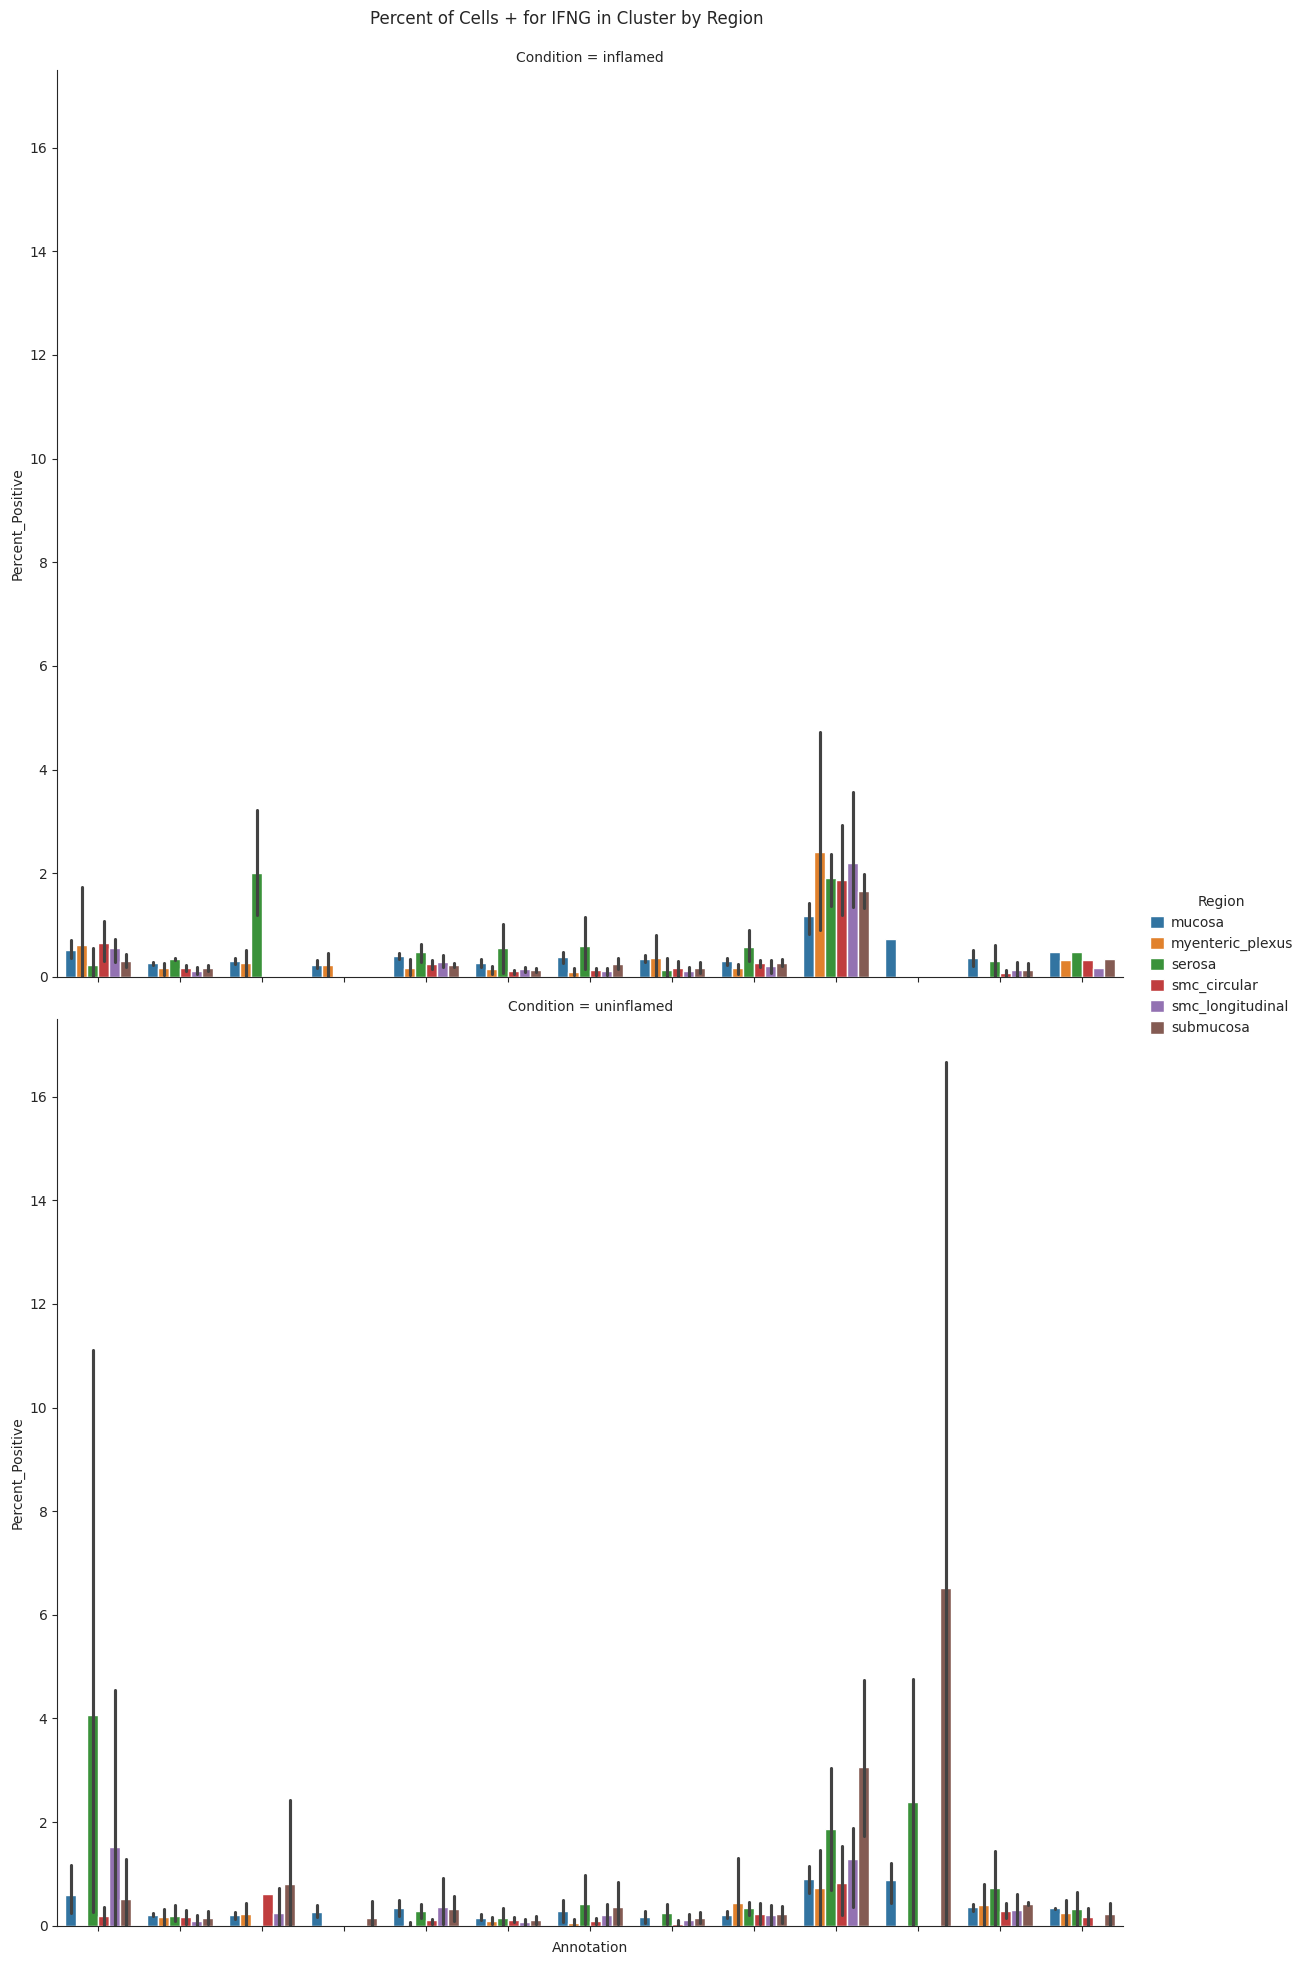

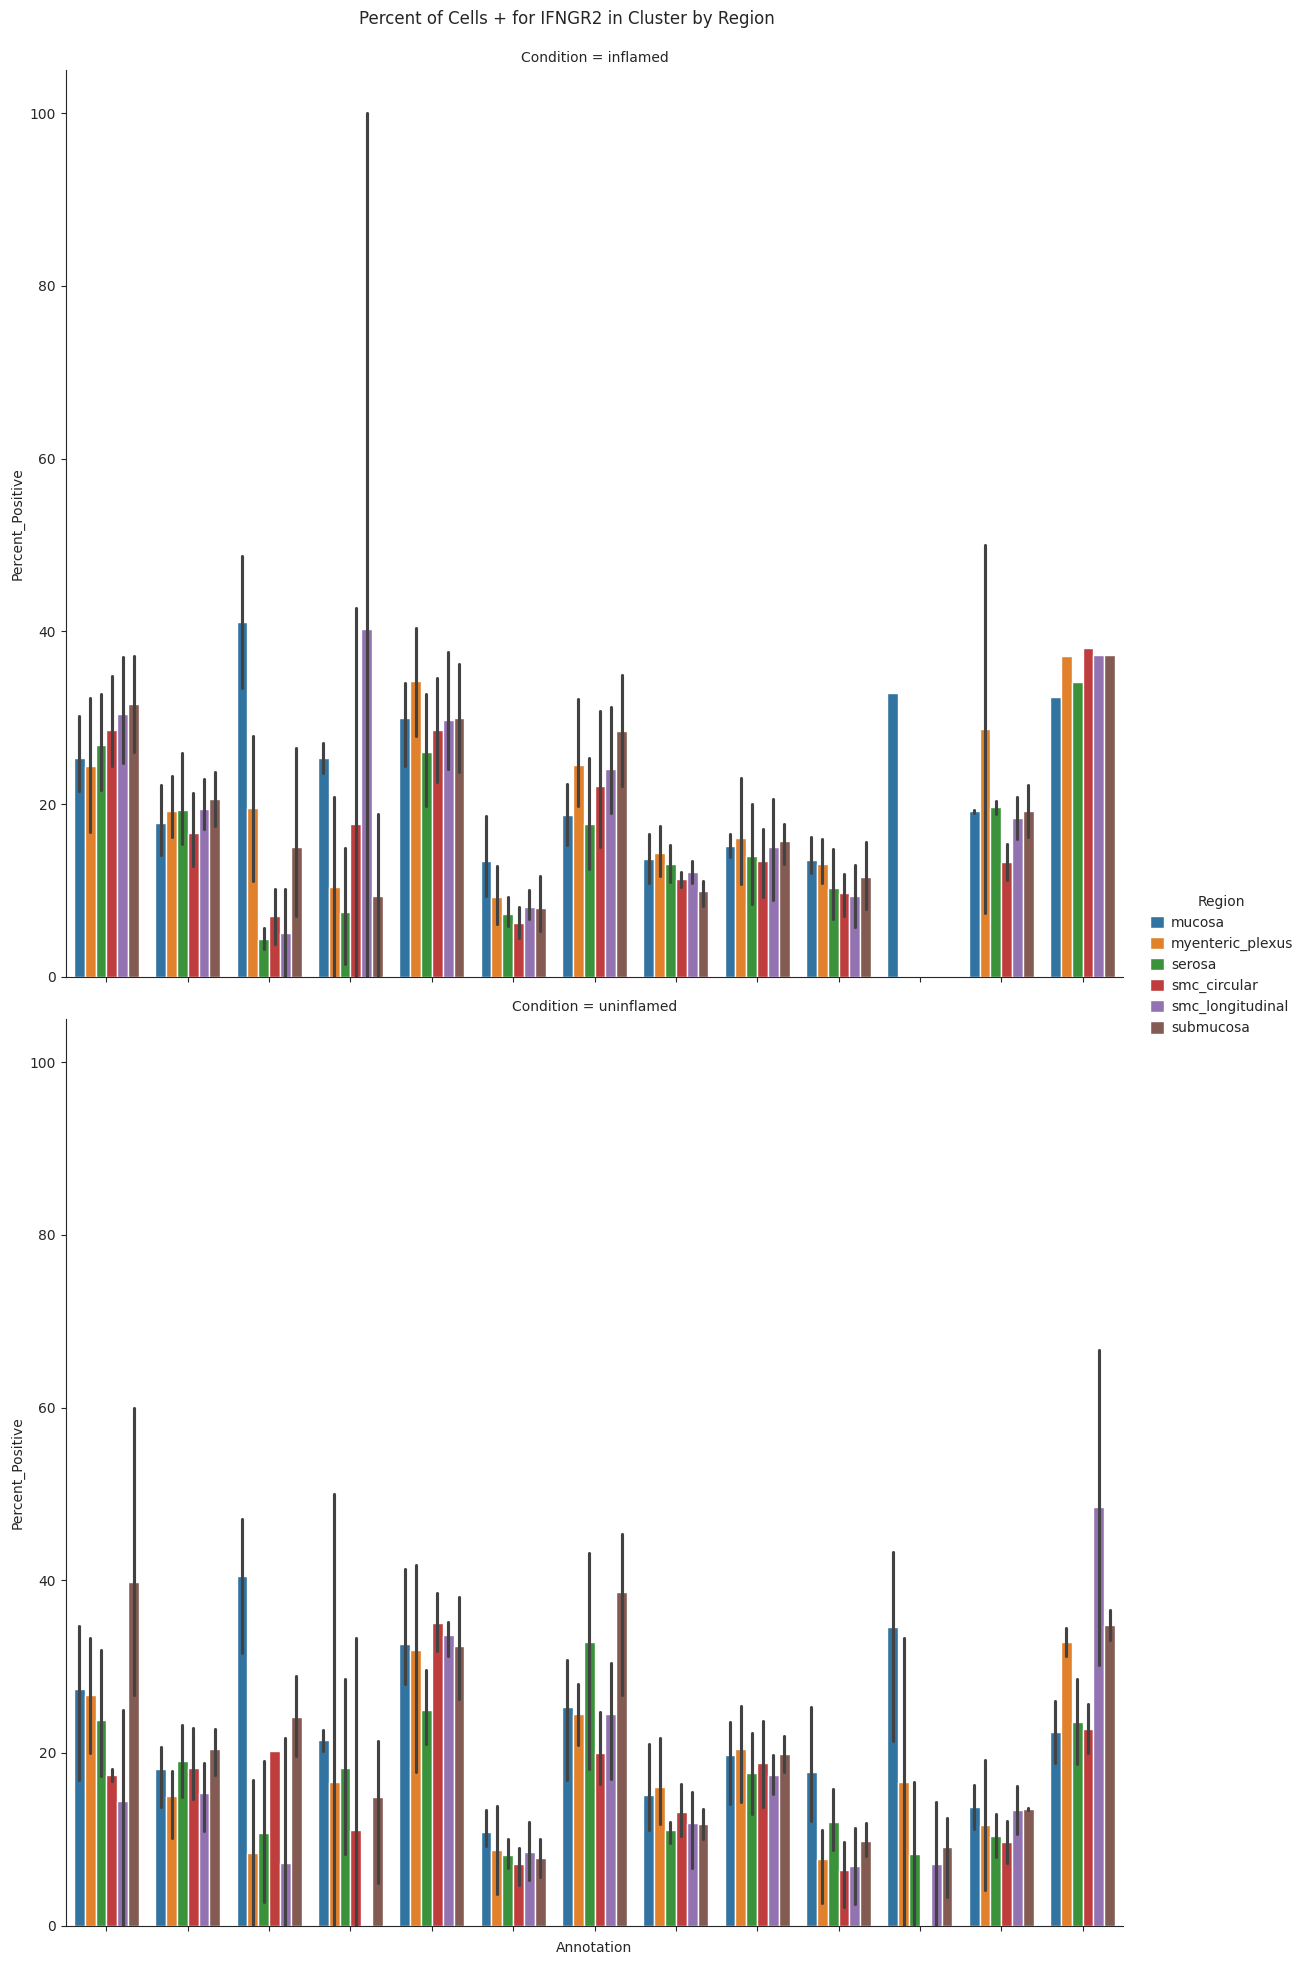

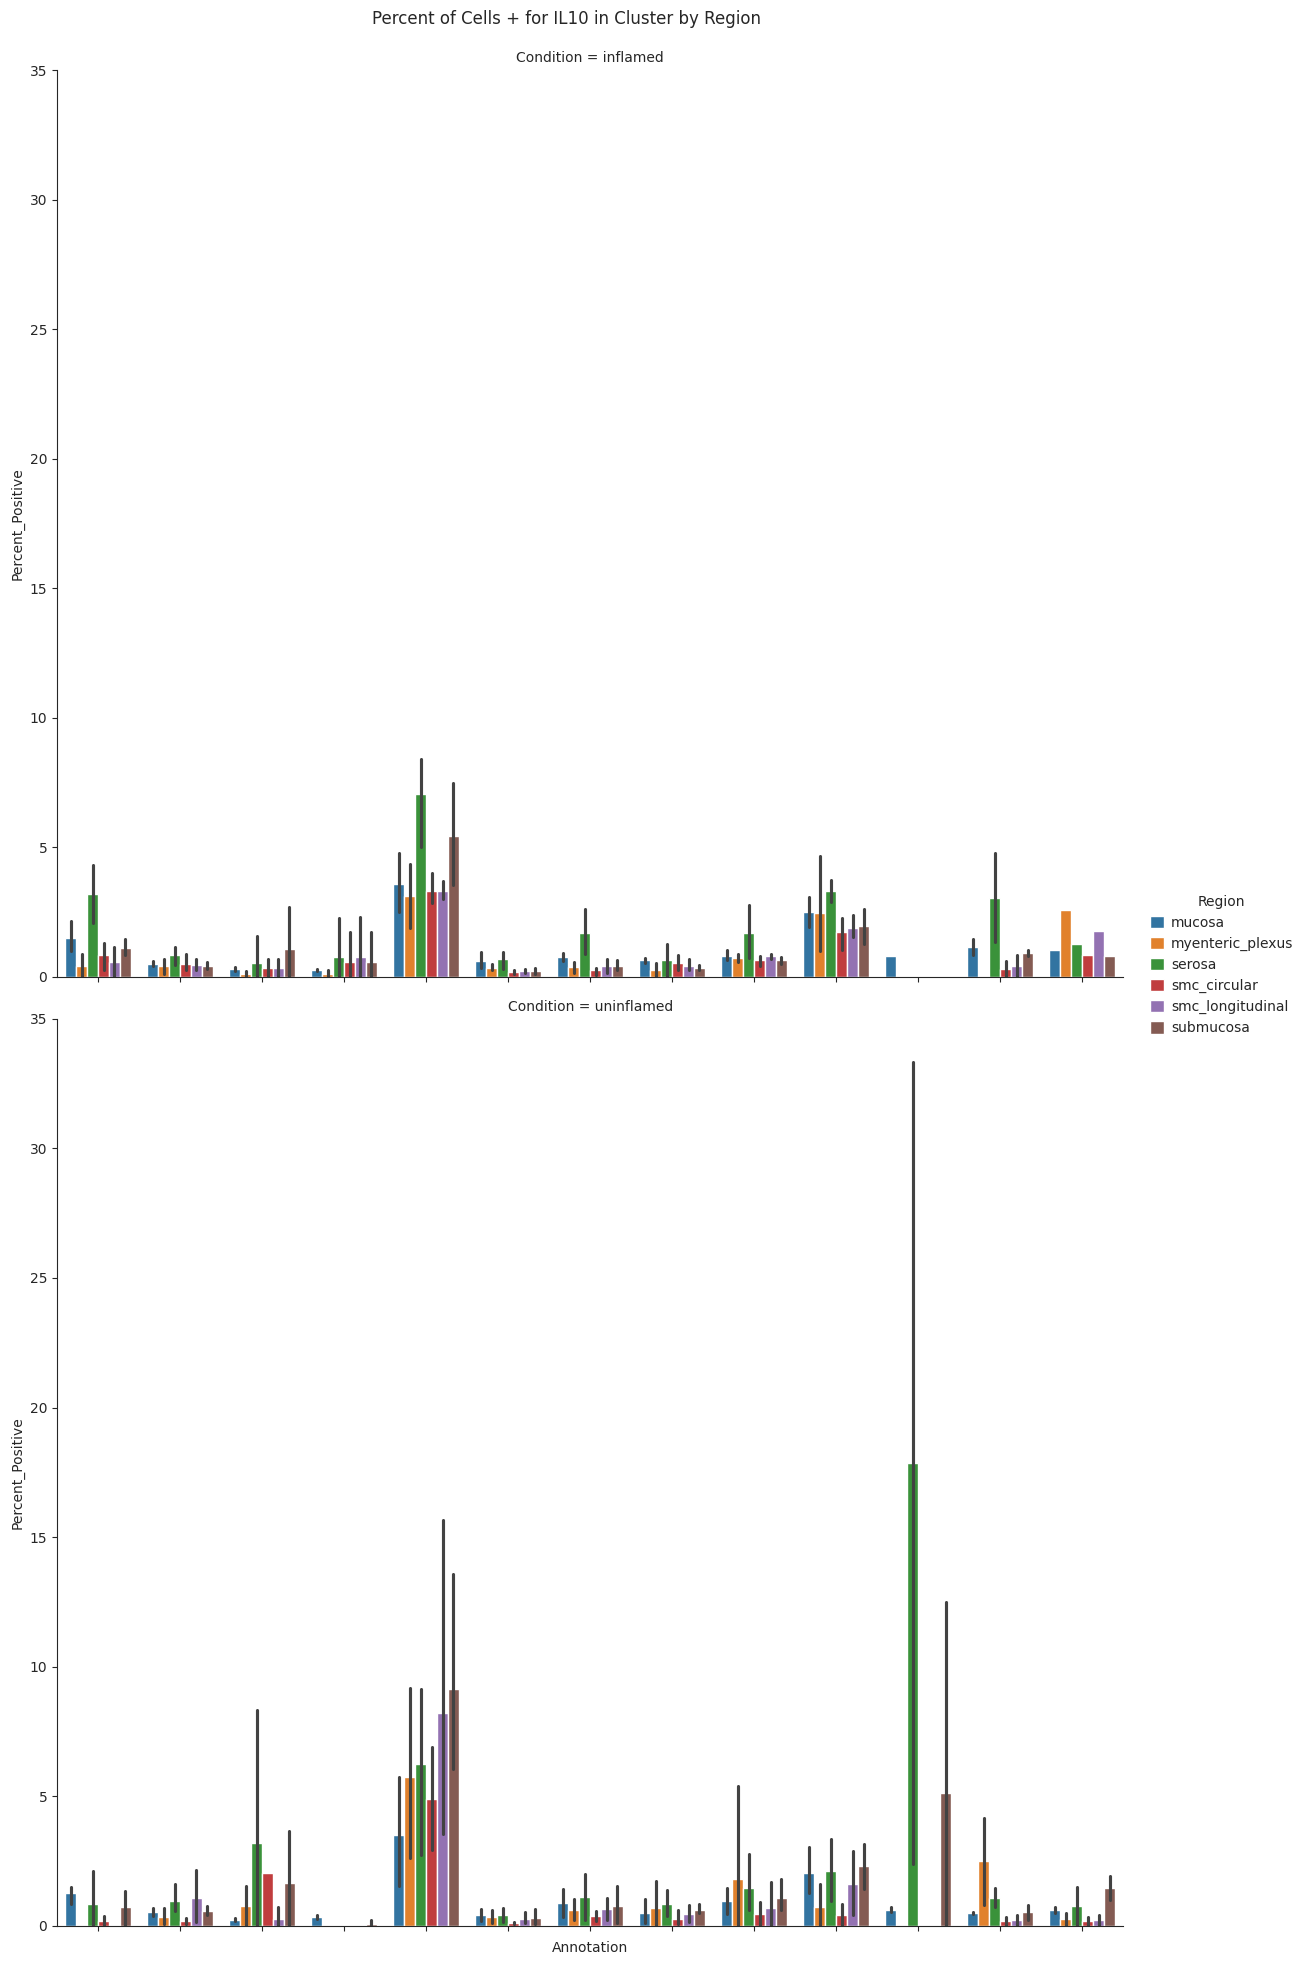

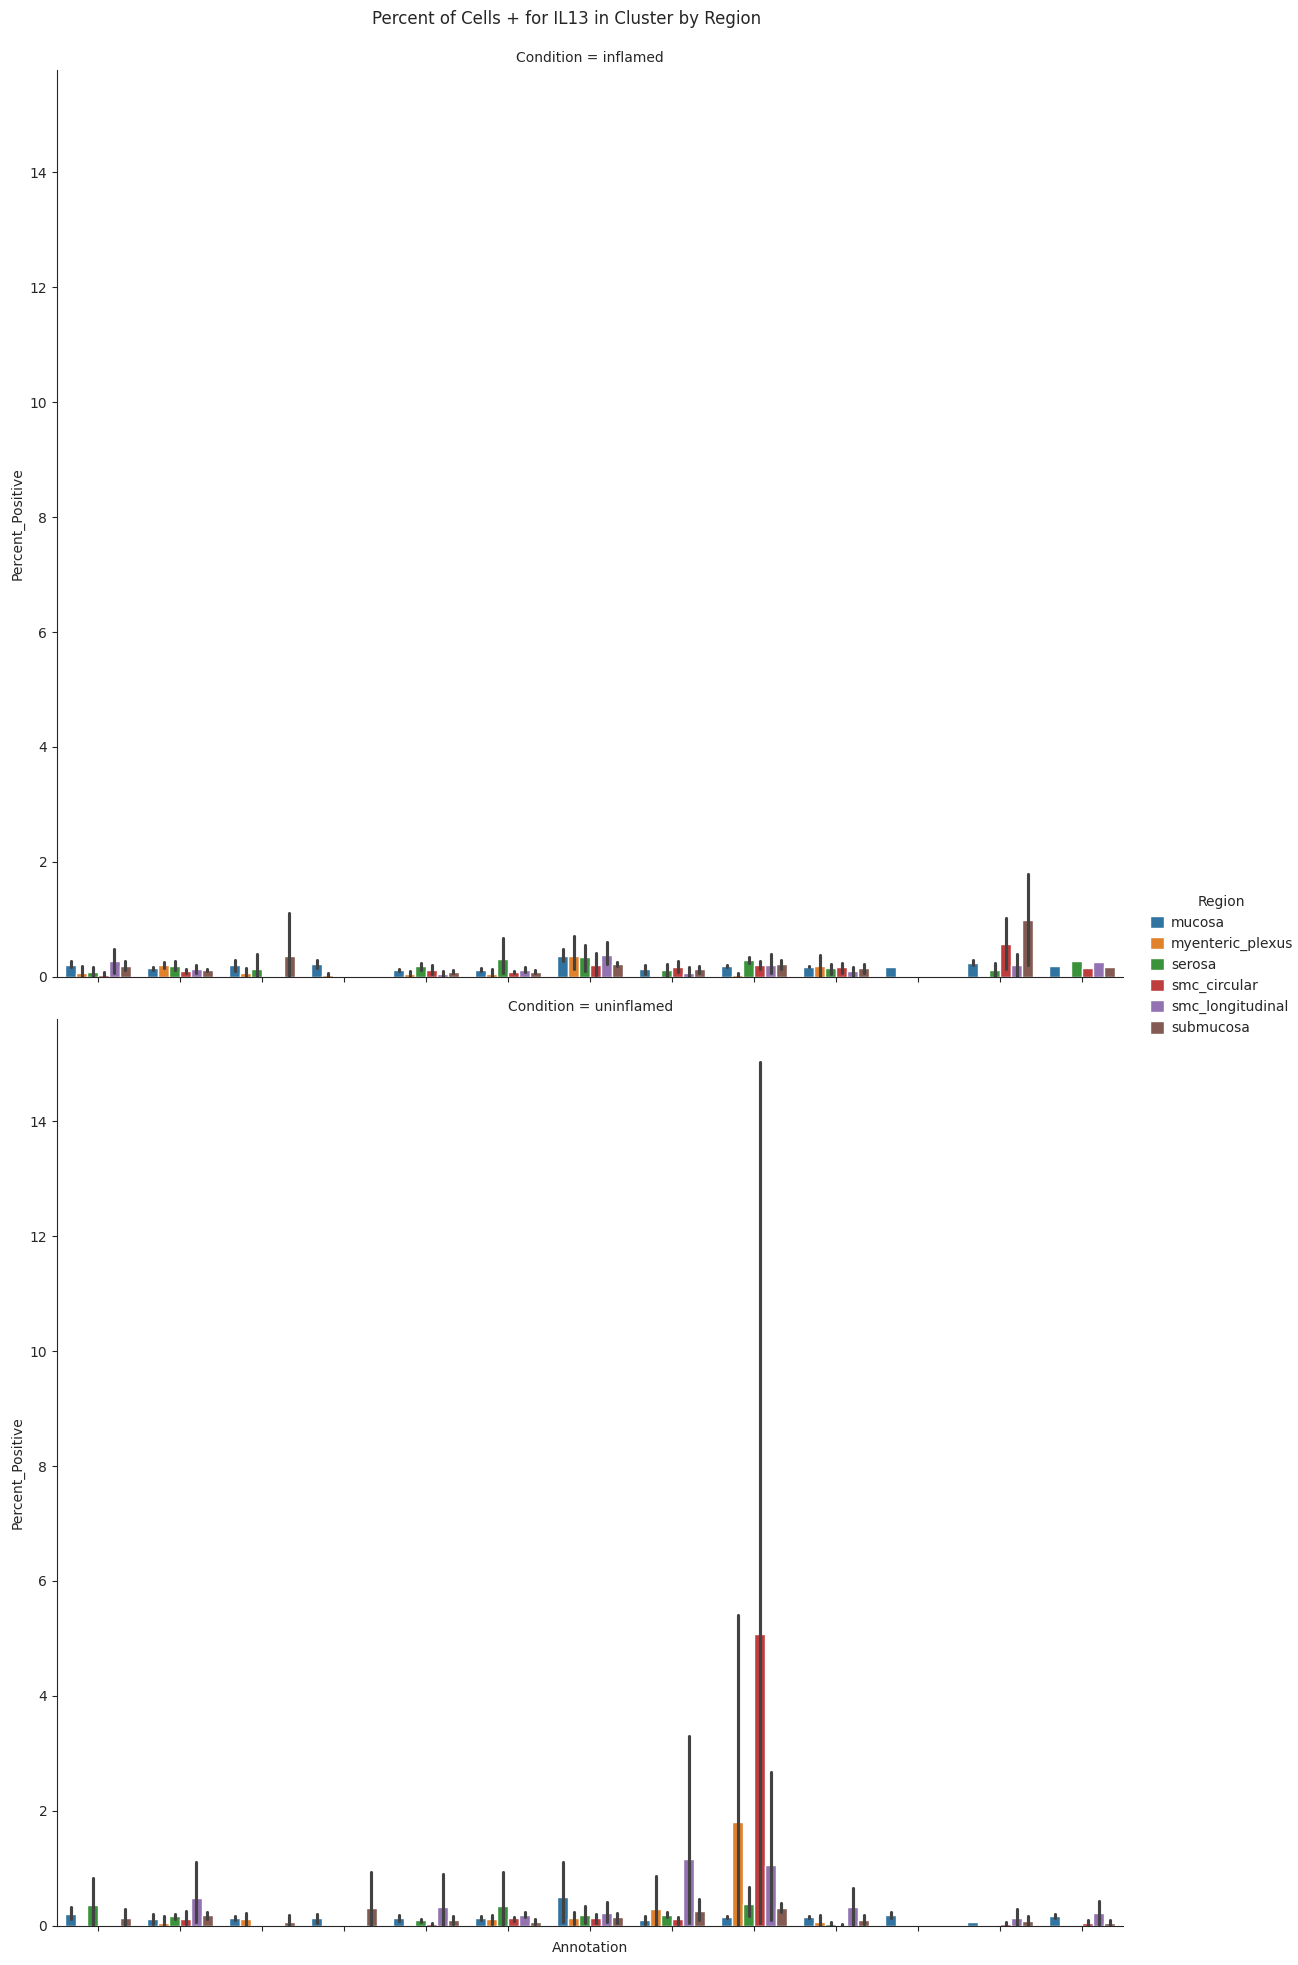

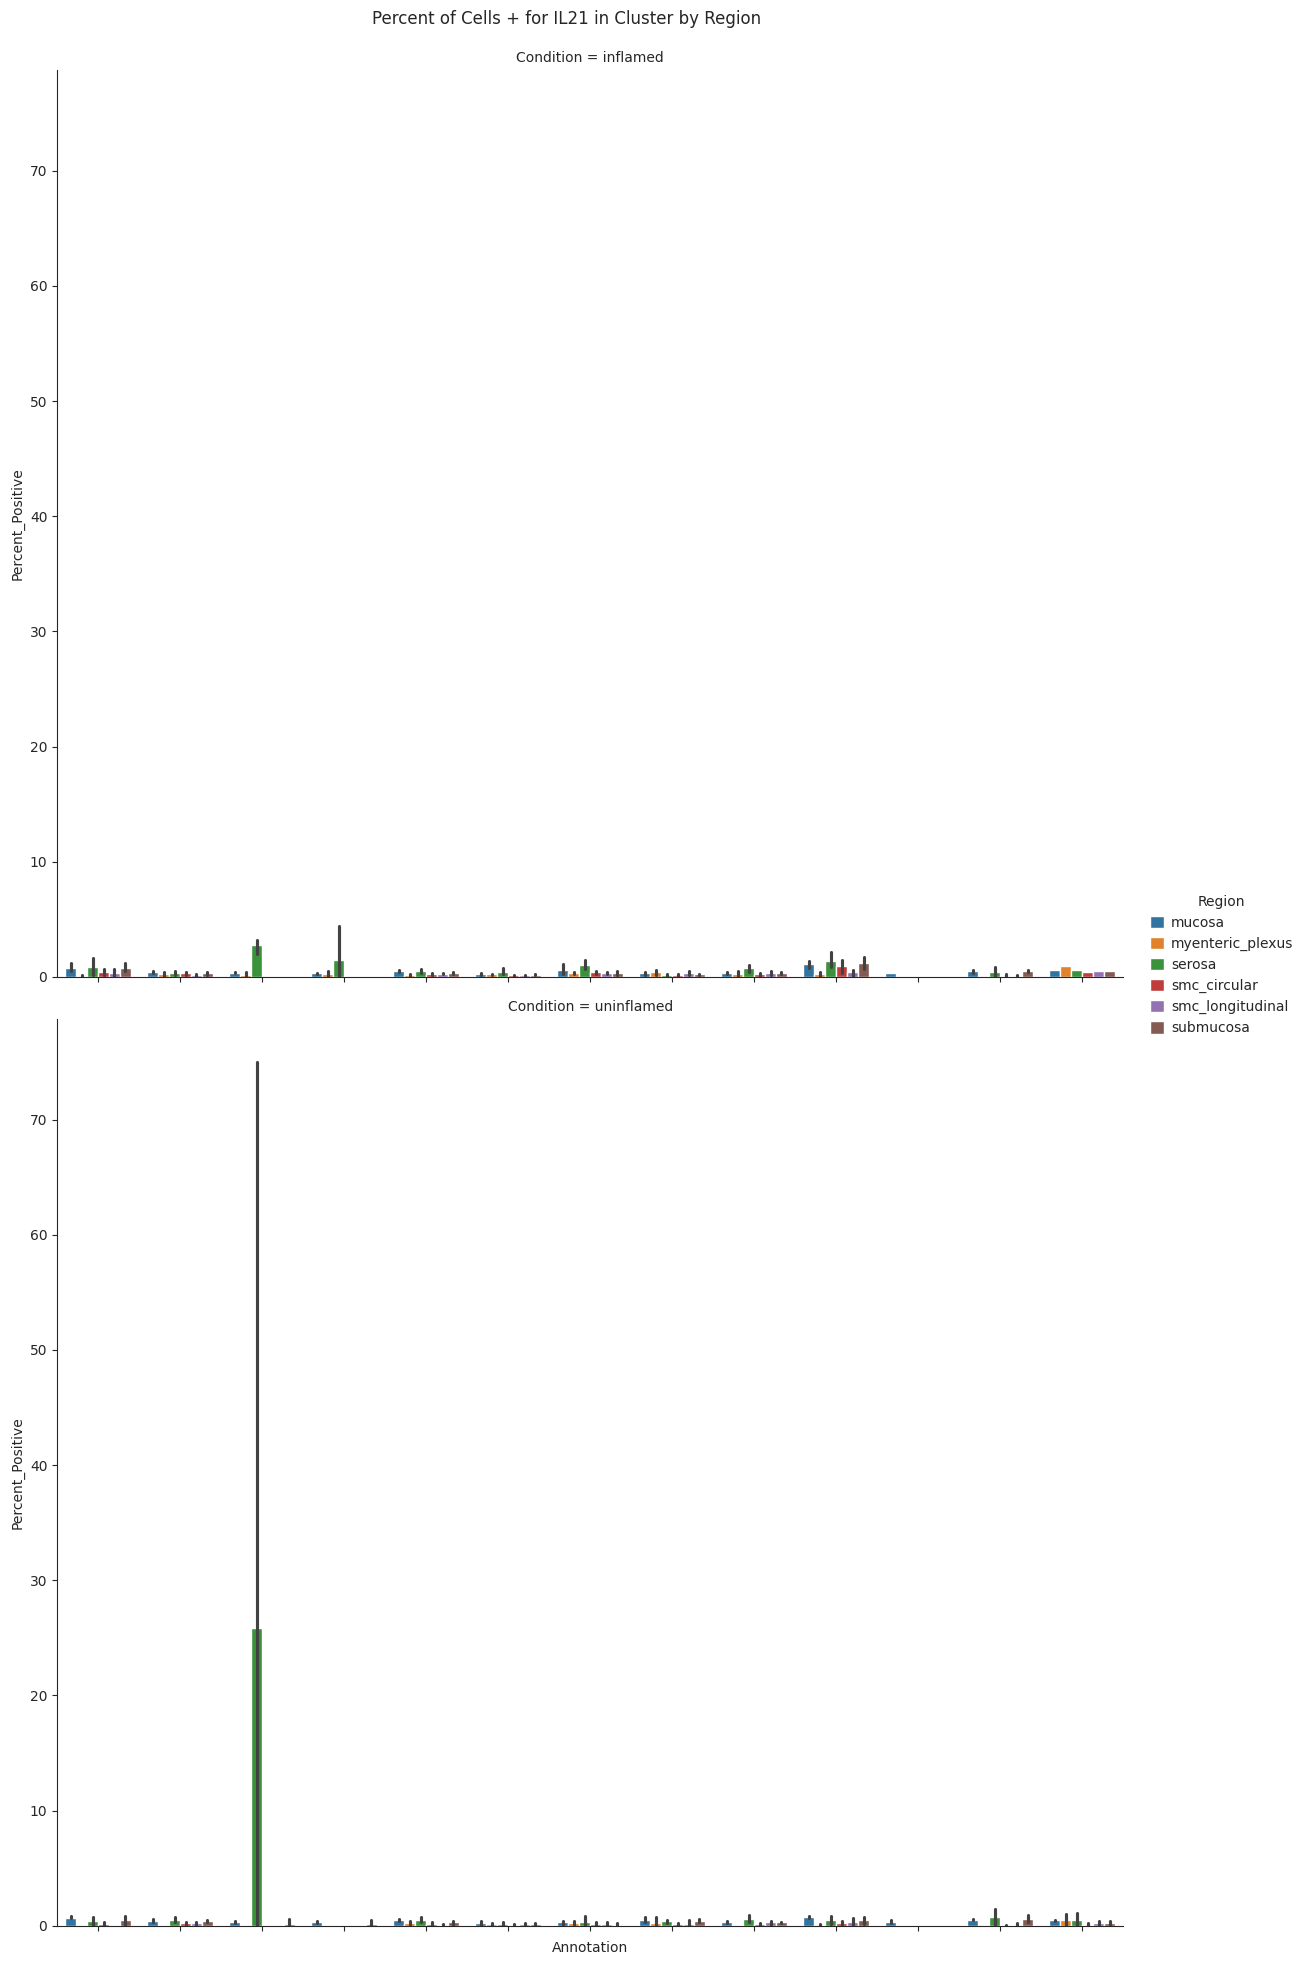

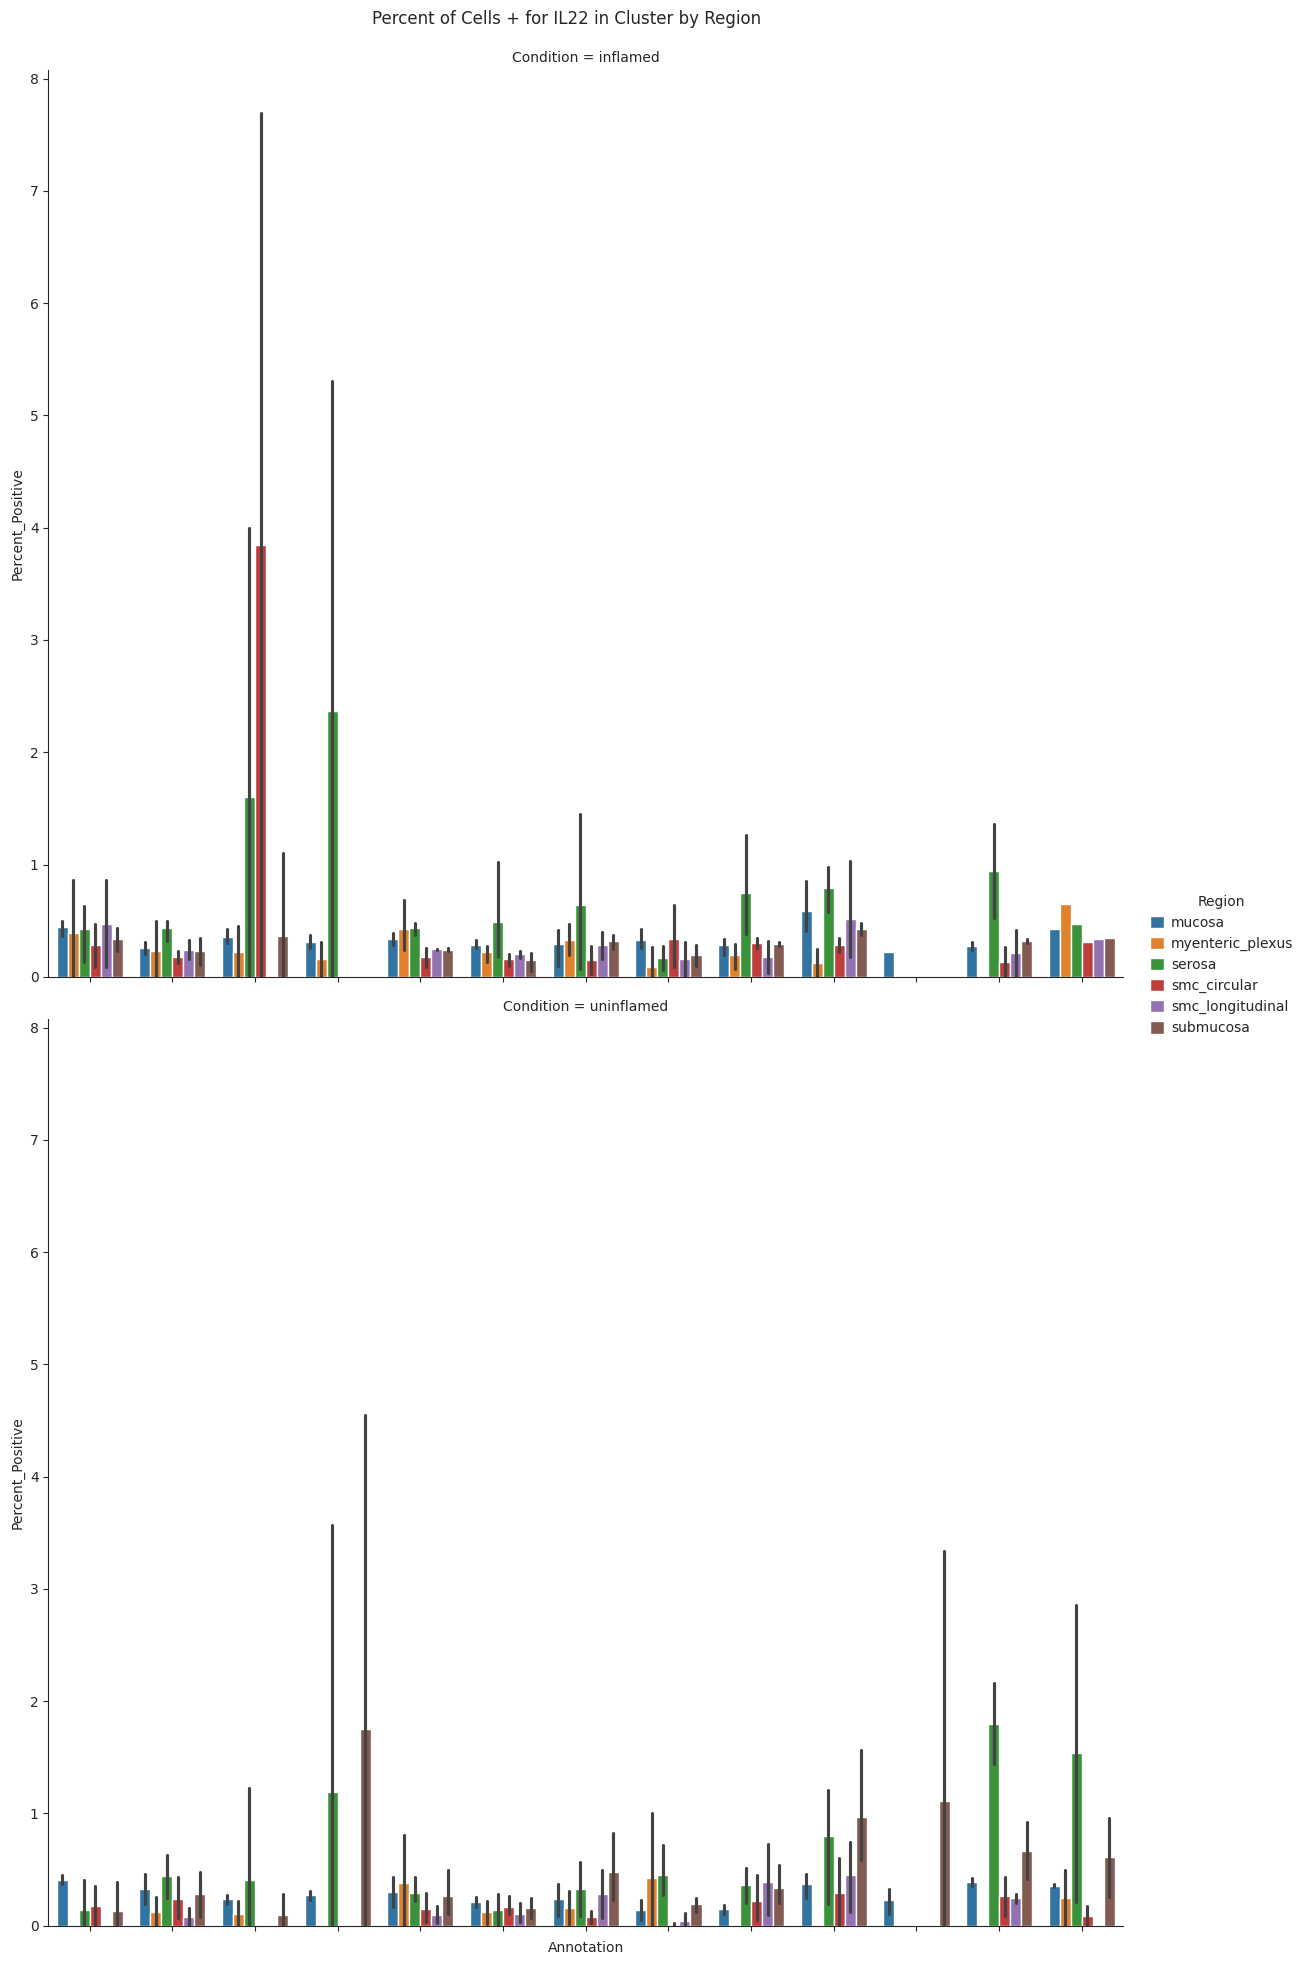

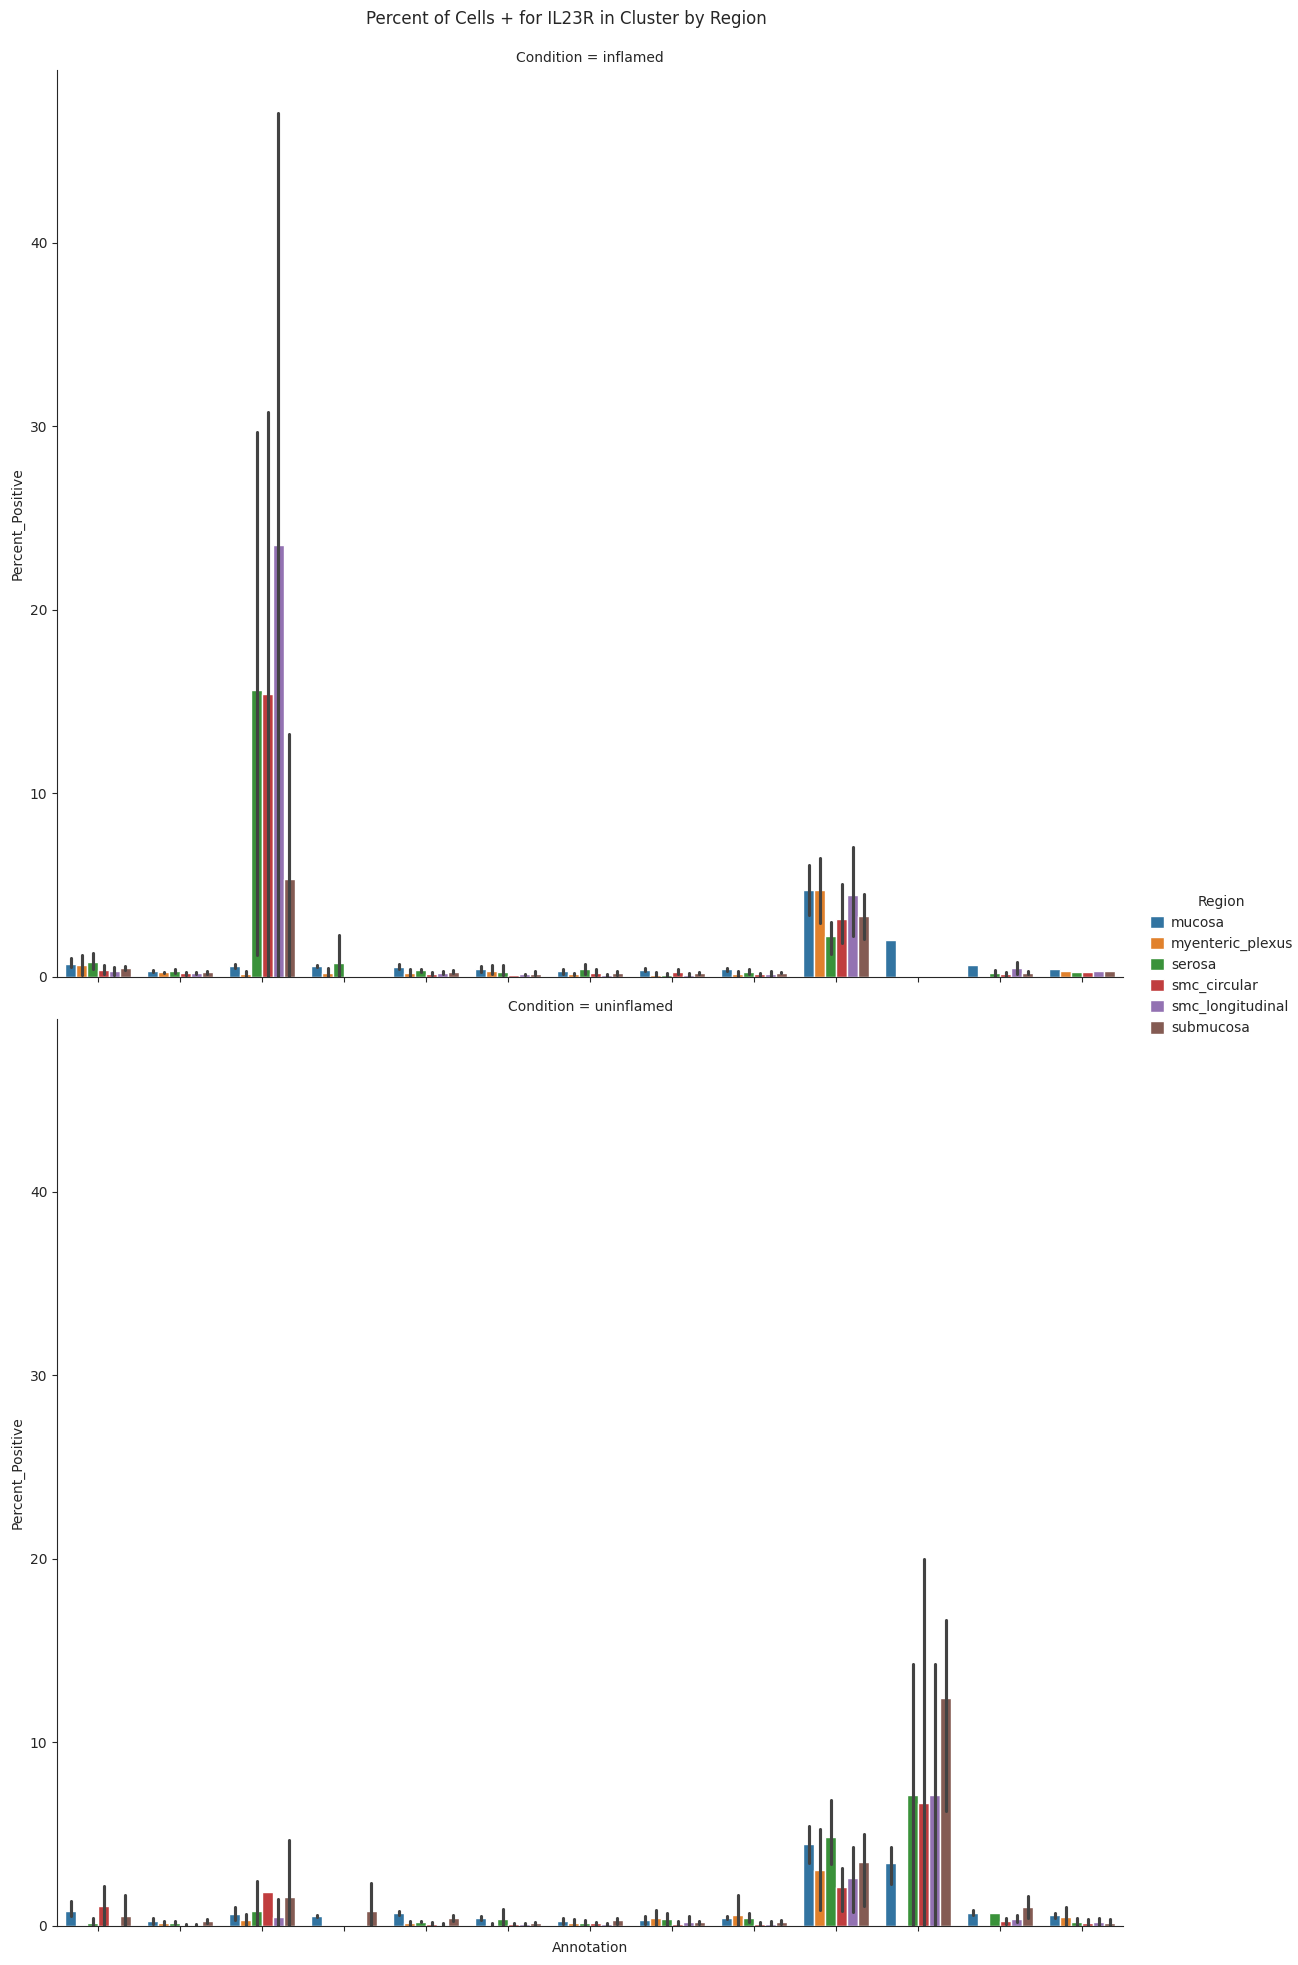

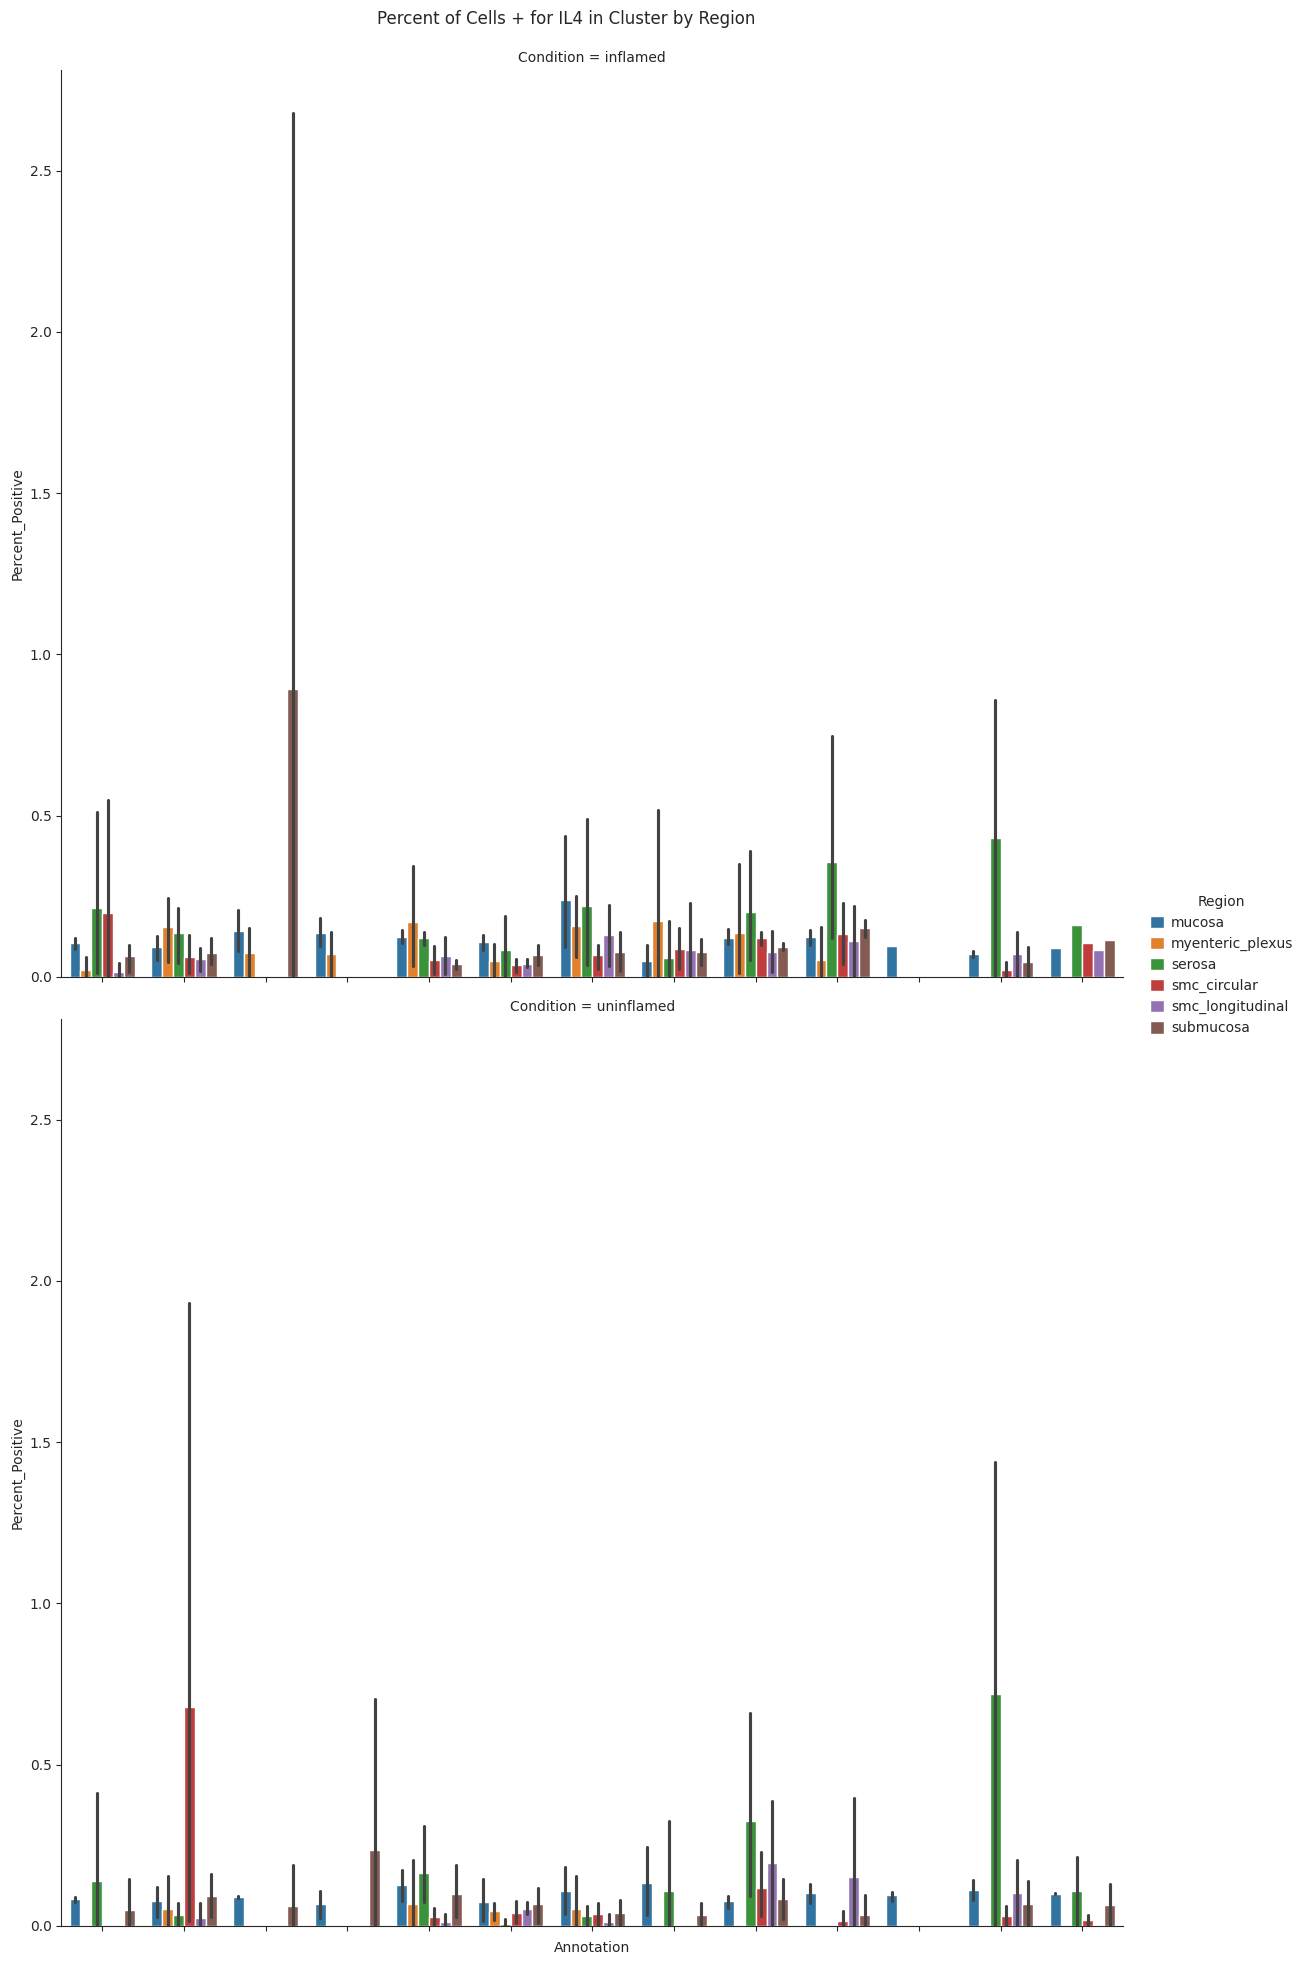

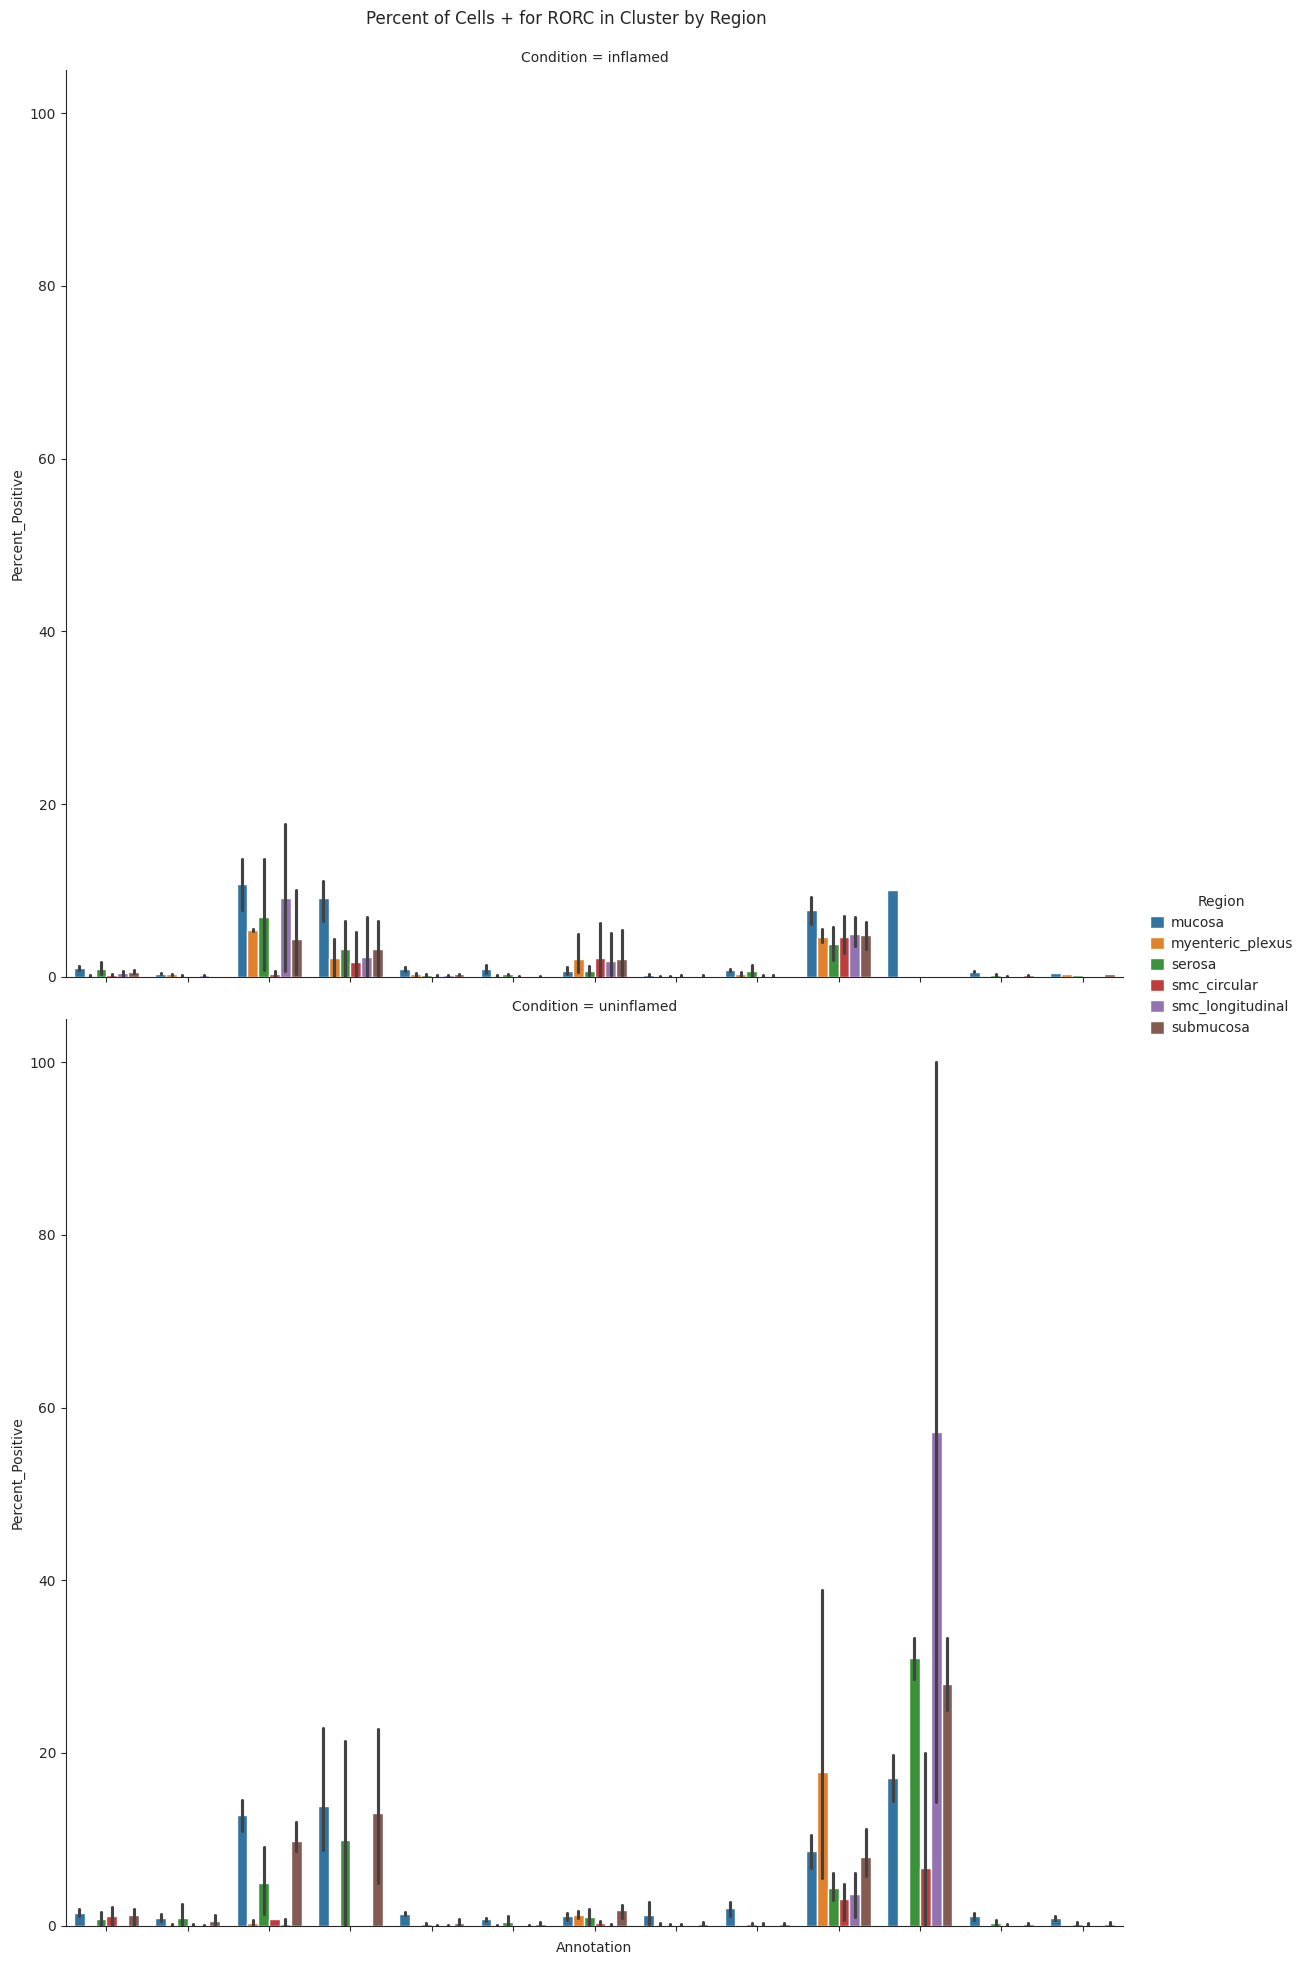

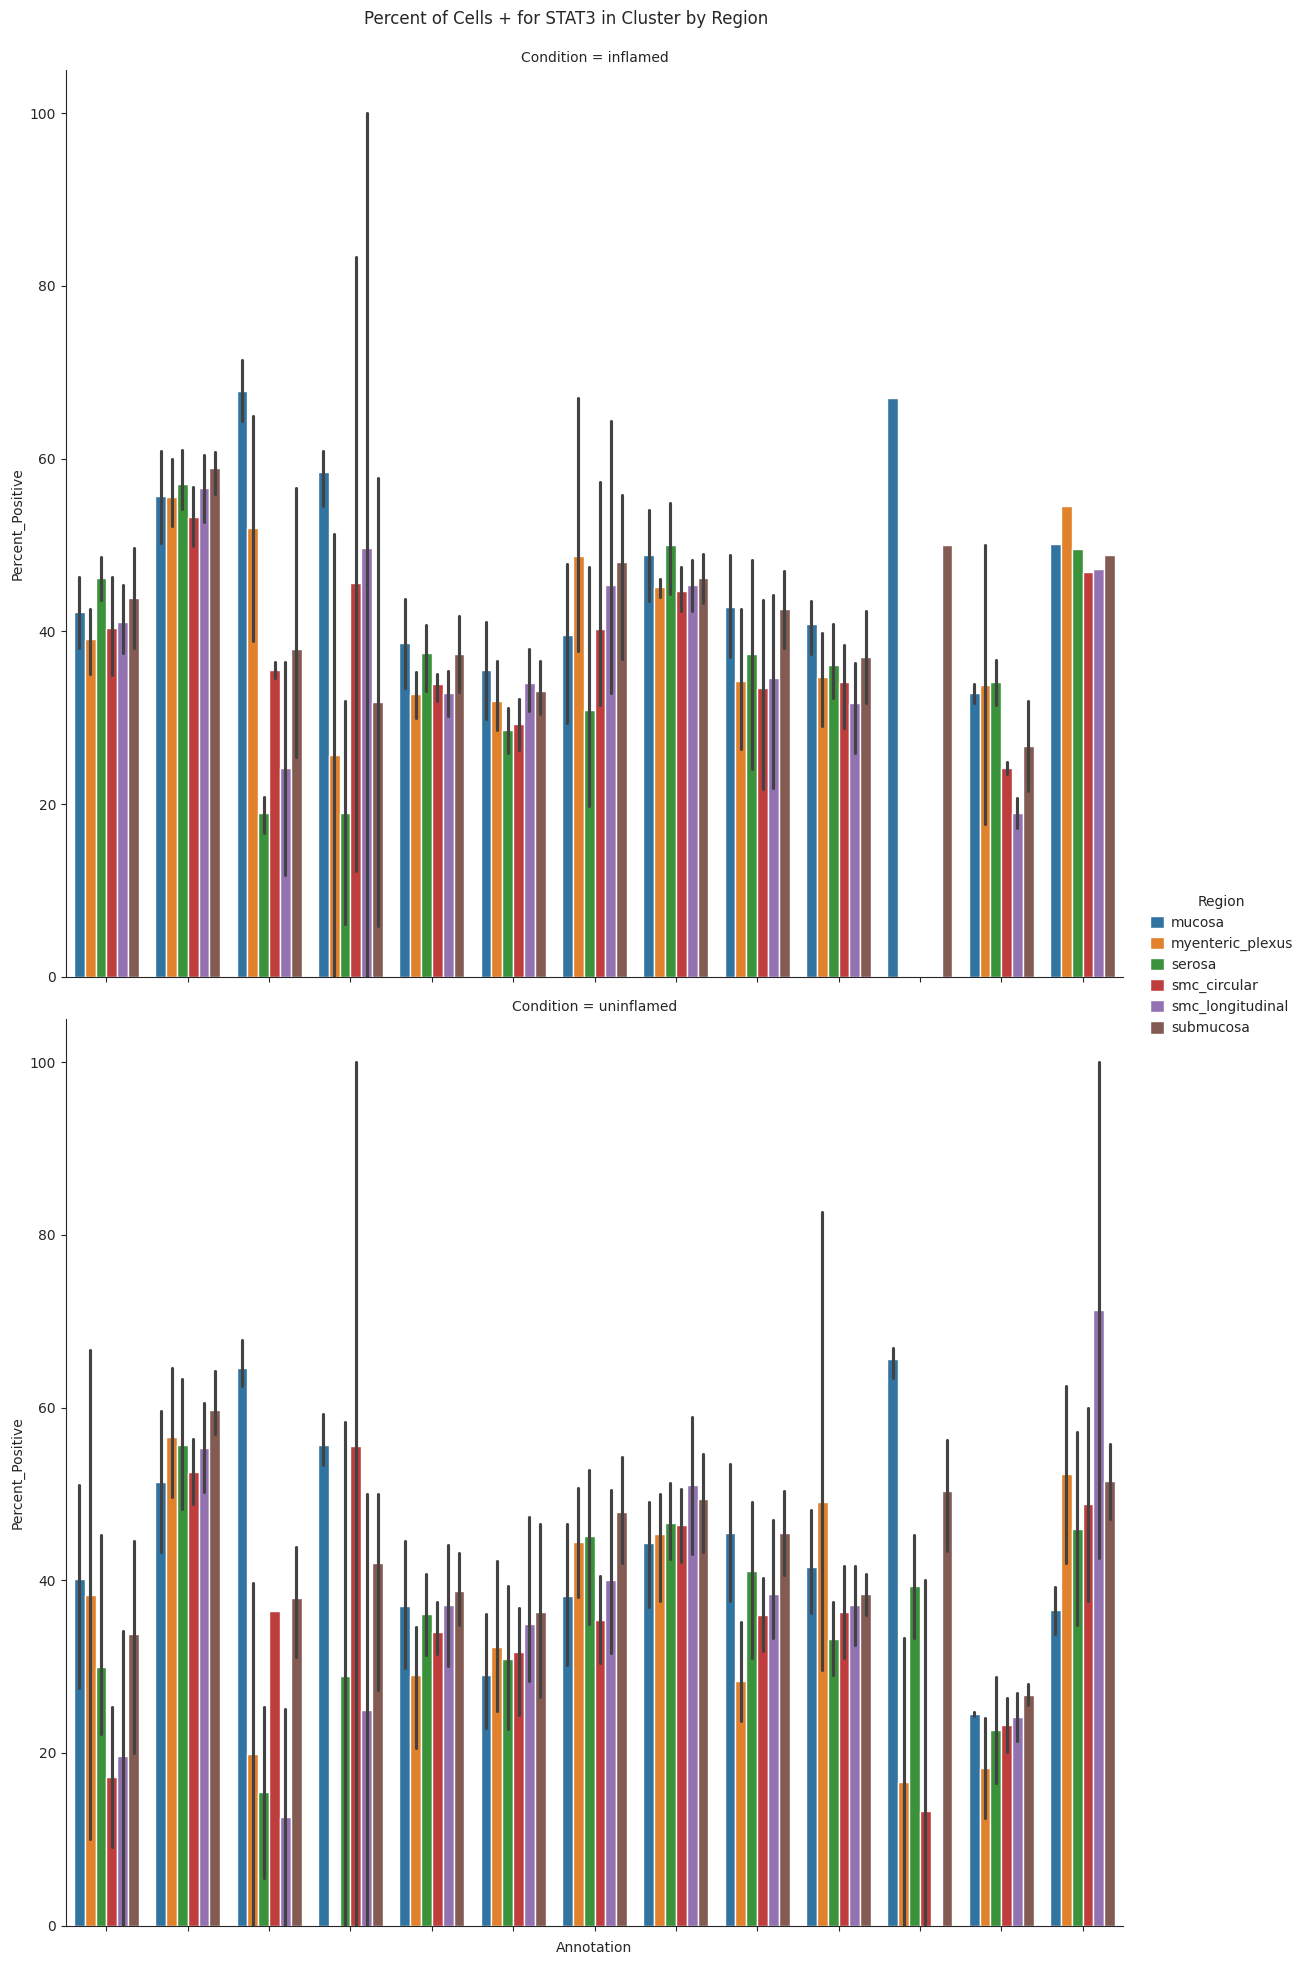

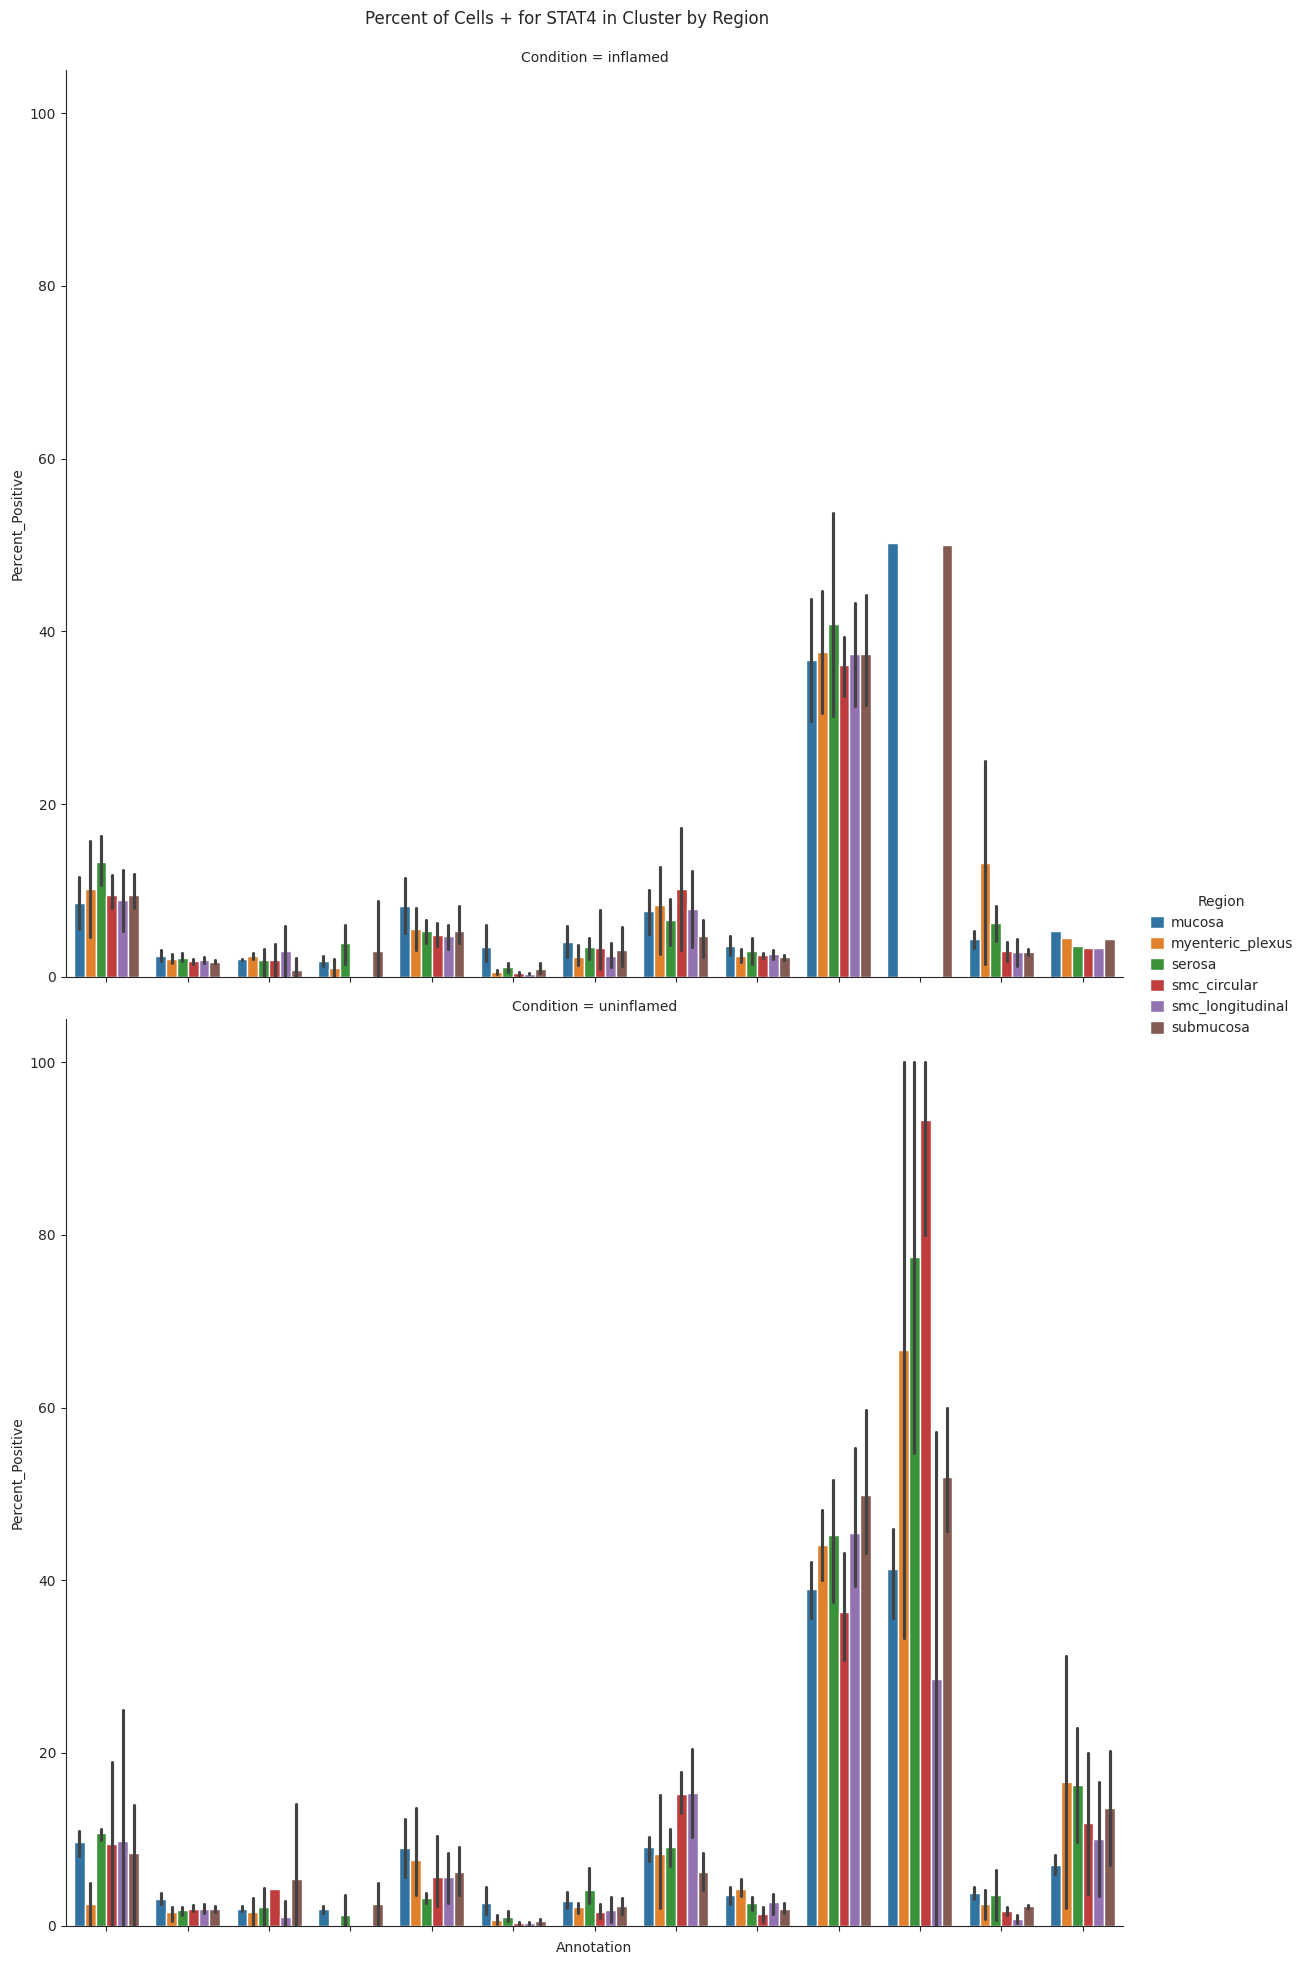

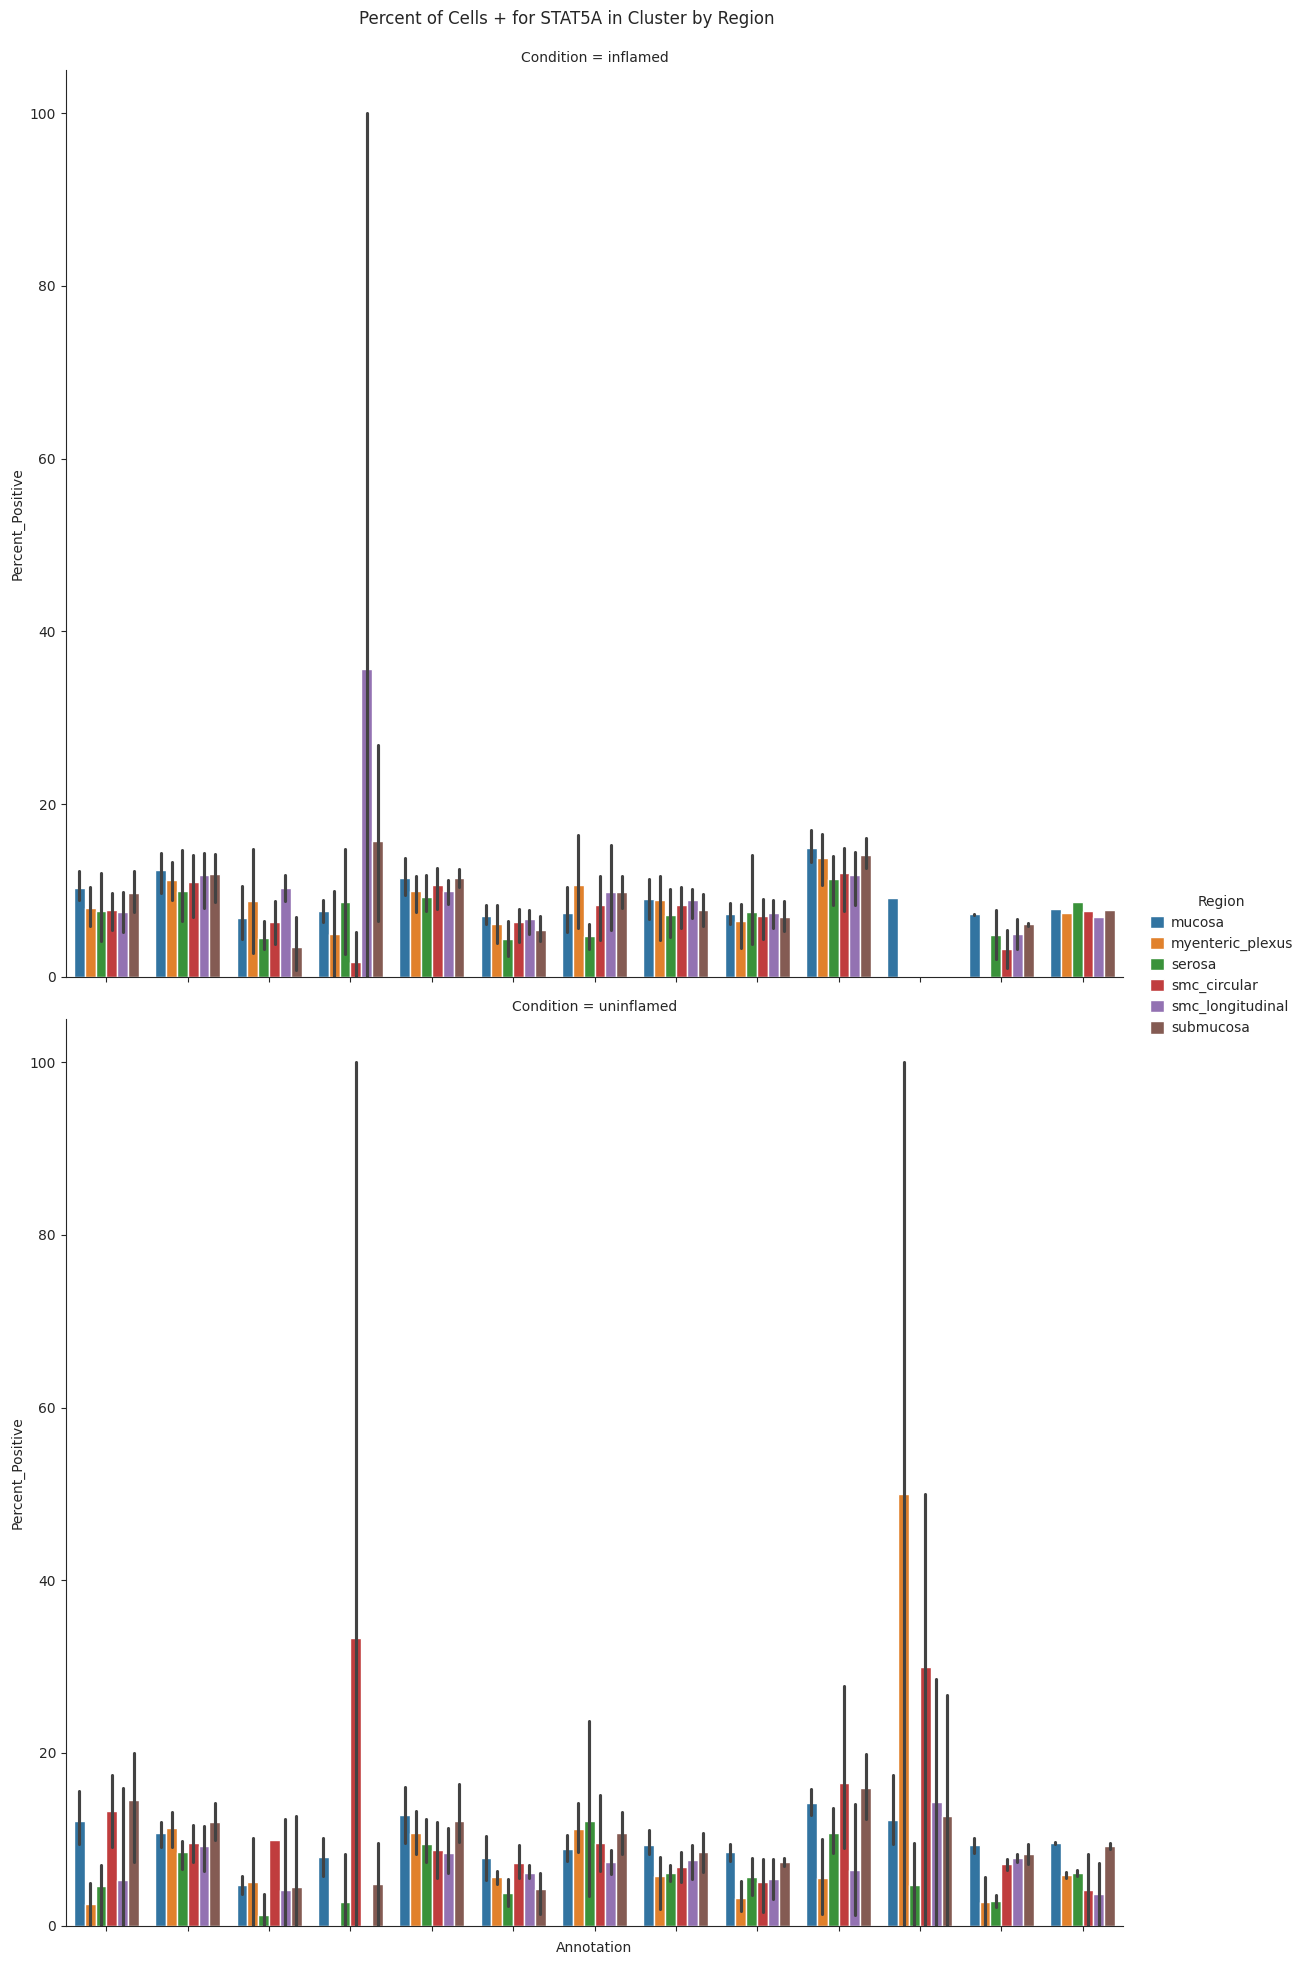

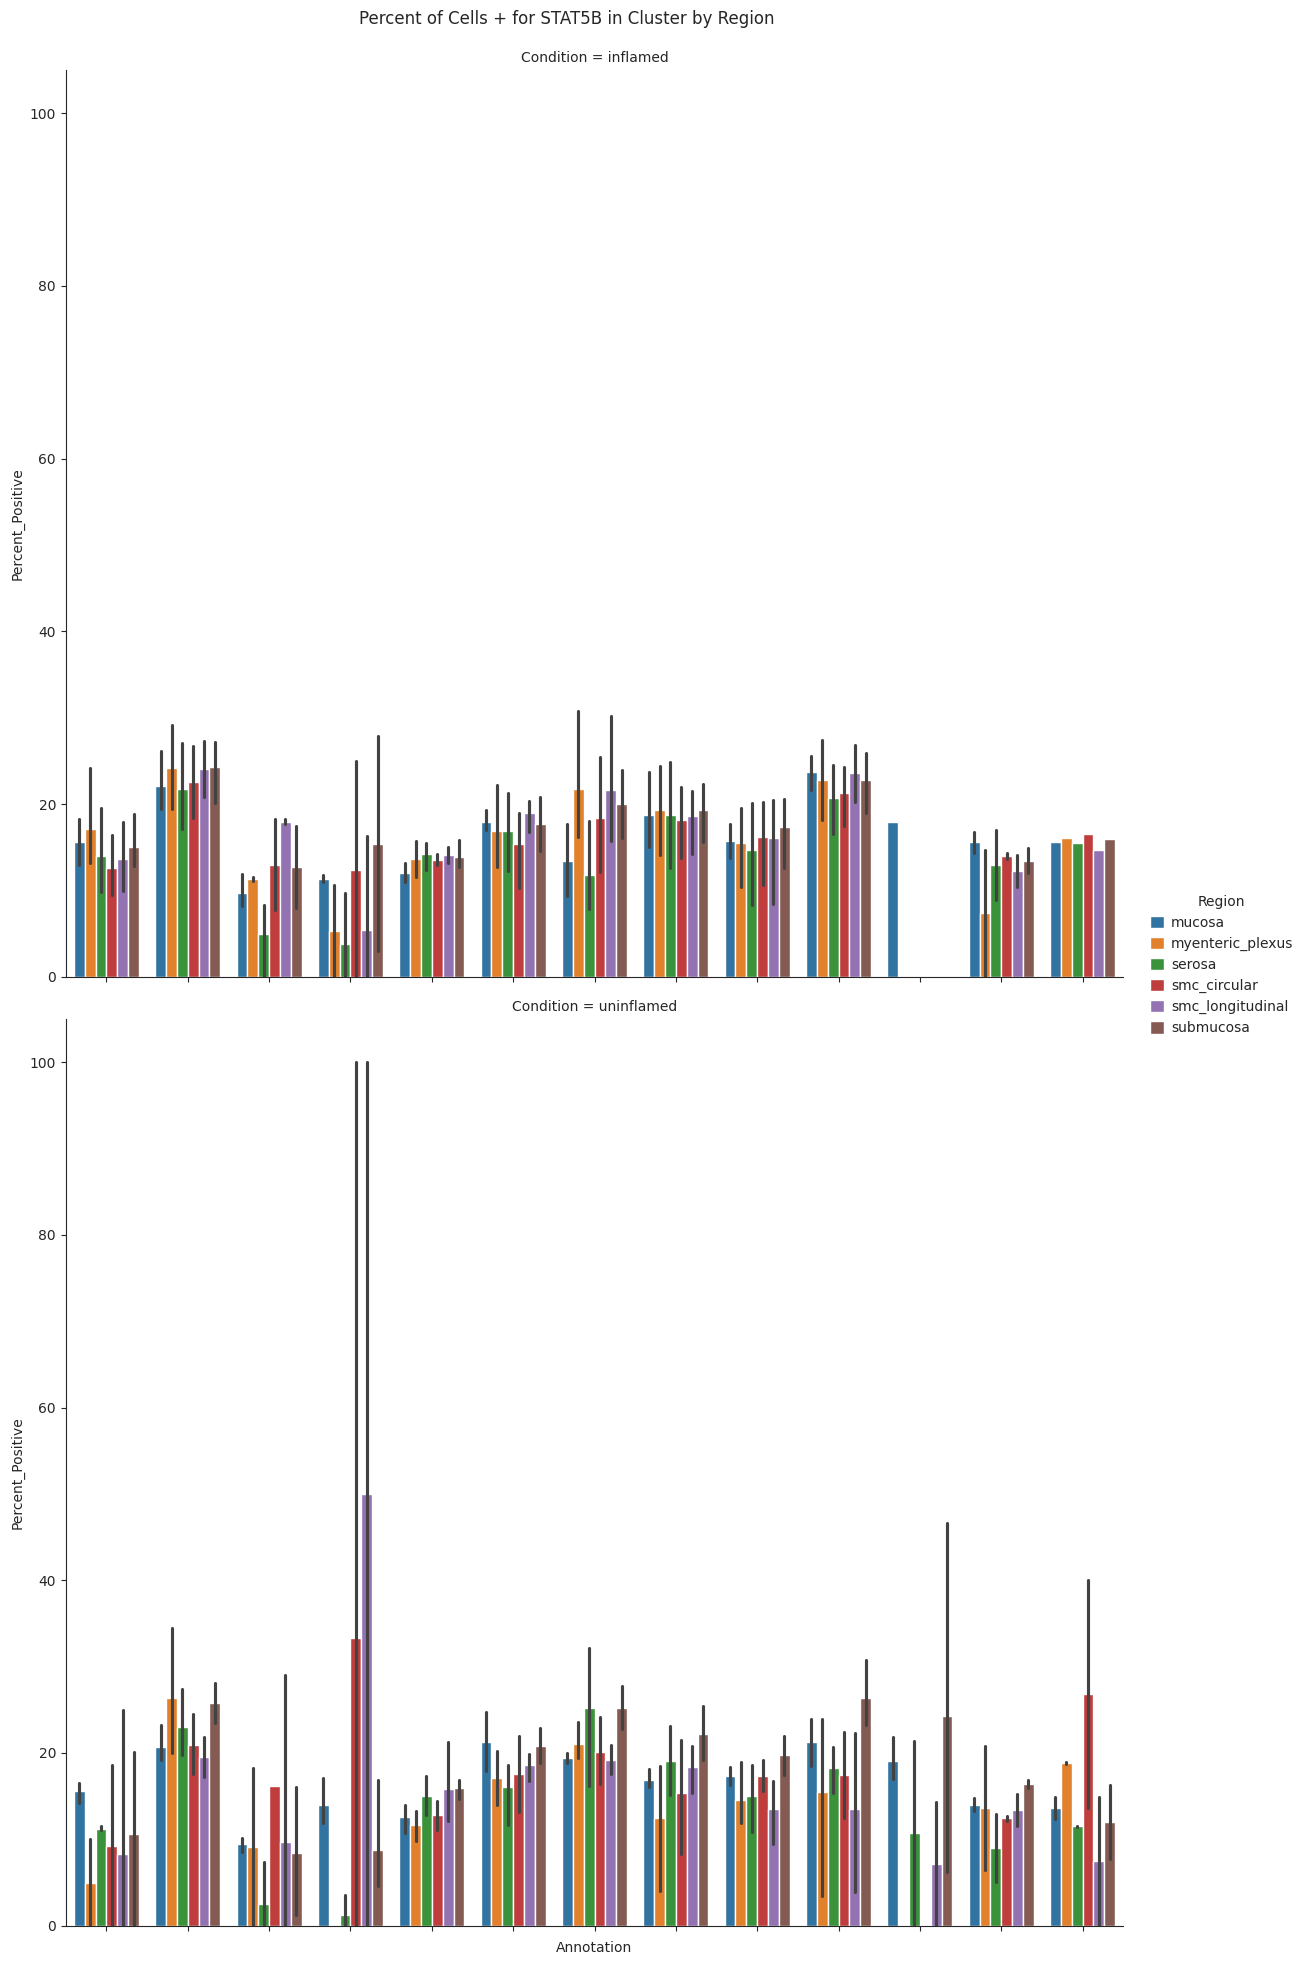

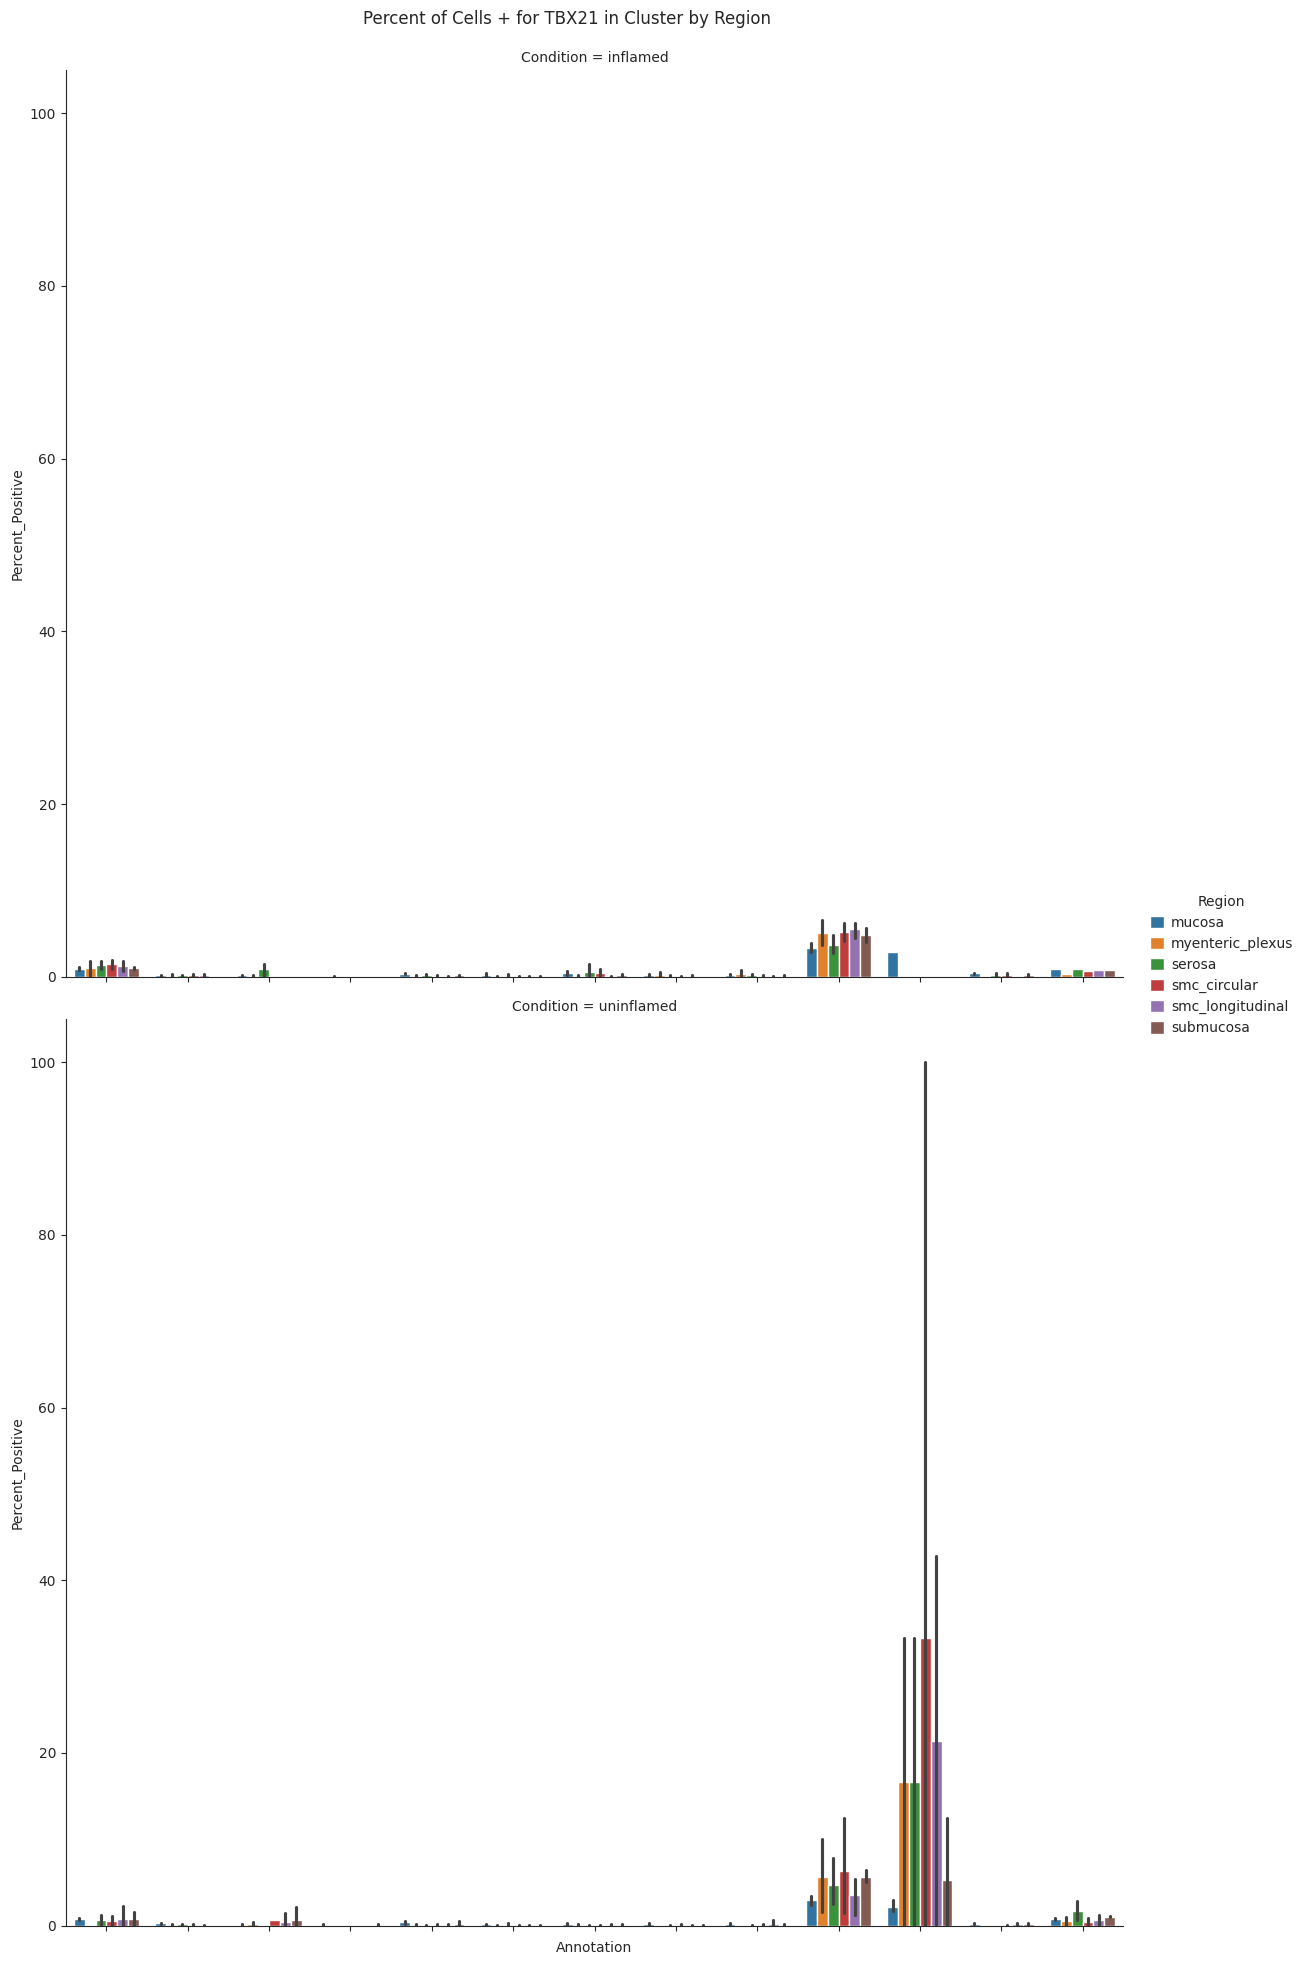

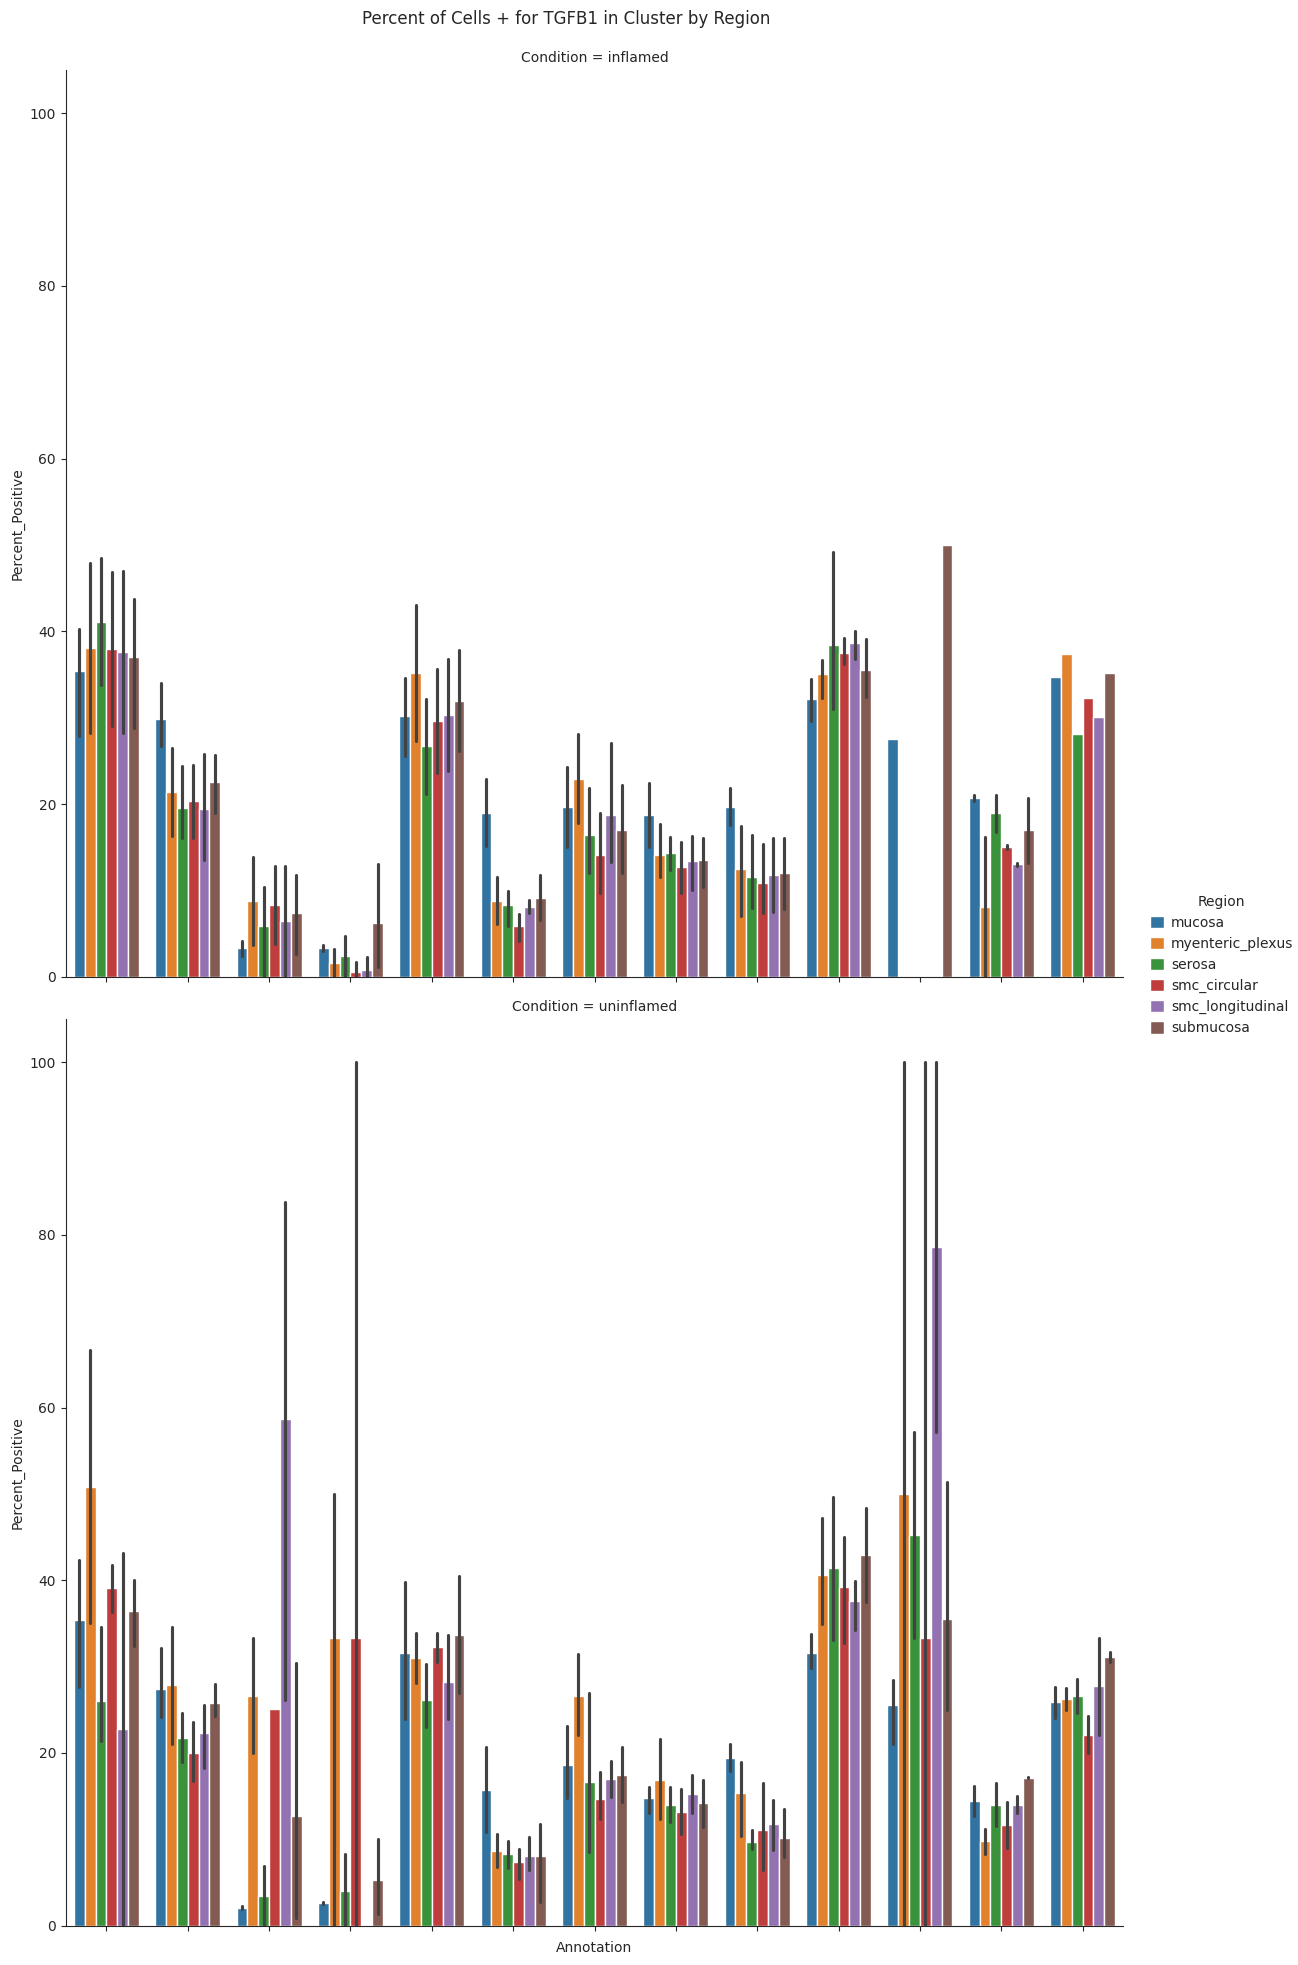

In [29]:
# for g in d_plot.reset_index().Gene.unique():
#     fig = sb.catplot(d_plot.reset_index()[d_plot.reset_index(
#         ).Gene == g], hue="Region", x=col_plot, y="Percent_Positive",
#                      row=col_condition, kind="bar", height=10)
#     fig.fig.suptitle(f"Percent of Cells + for {g} in Cluster by Region")
#     fig.set_xticklabels(rotation=45)
#     fig.fig.tight_layout()
#     fig.legend.set_bbox_to_anchor((1, 0.5))
#     fig.legend.set_loc("center left")
#     plt.subplots_adjust(top=0.95)
#     sss = "_".join(d_plot.reset_index().Region.unique()) + f"__{g}"
#     # plt.savefig(os.path.join(out_dir, "quantification",
#     #                          f"n_cells_positive_{sss}.jpeg"),
#     #             bbox_inches="tight", dpi=300)
#     # plt.show()\

In [ ]:
for g in d_plot.reset_index().Gene.unique():
    sss = "_".join(d_plot.reset_index("Region").Region.unique()) + f"__{g}"
    fig = sb.catplot(d_plot.reset_index()[d_plot.reset_index(
        ).Gene == g], x="Region", hue=col_plot, kind="bar",
                     palette="rainbow", y="Percent_Positive",
                     col=col_condition, height=10)
    fig.fig.suptitle(f"Percent of Cells + for {g} in Cluster by Region")
    fig.set_xticklabels(rotation=45)
    fig.fig.tight_layout()
    fig.legend.set_bbox_to_anchor((1, 0.5))
    fig.legend.set_loc("center left")
    plt.subplots_adjust(top=0.95)
    # plt.savefig(os.path.join(out_dir, "quantification",
    #                          f"n_cells_positive_{sss}_ann.jpeg"),
    #             bbox_inches="tight", dpi=300)
    # plt.show()

In [ ]:
sb.catplot(results_ann, col="Gene", row="Region", x=col_plot, y="Percent",
           hue=col_condition, kind="violin", cut=0,
           height=5 * len(results_ann.reset_index().Region.unique()),
           margin_titles=True, split=True)

## Distribution of Cell Types

In [ ]:
fig = sb.catplot(d_plot, x="Region", hue=col_plot,
                 hue_order=regions, kind="bar",
                 y="Percent_Composition", col=col_condition, height=20)
plt.legend(fontsize=18)  # Set font size to 12

In [ ]:
fig = sb.catplot(d_plot, hue="Region", x=col_plot,
                 y="Percent_Composition",  kind="bar", hue_order=regions,
                 col=col_condition, height=20)
fig.fig.suptitle("Percent of Sample Cells in Cluster by Region", fontsize=24)
fig.set_titles("{col_name}", size=20)
fig.set_xticklabels(rotation=45, fontsize=18)
fig.fig.tight_layout()
fig.legend.set_bbox_to_anchor((1, 0.5))
fig.legend.set_loc("center left")
plt.legend(fontsize=18)  # Set font size to 12
plt.savefig(os.path.join(out_dir, "quantification",
                         f"sample_cell_type_composition_ann.jpeg"),
            bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
fig = sb.catplot(d_plot, col="Region", x=col_plot, kind="bar",
                 col_order=regions, palette=palette,
                 y="Percent_Composition", hue=col_condition, height=20)
fig.fig.suptitle("Percent of Sample Cells in Cluster by Region", fontsize=24)
fig.set_titles("{col_name}", size=20)
fig.set_xticklabels(rotation=45, fontsize=18)
fig.fig.tight_layout()
fig.legend.set_bbox_to_anchor((1, 0.5))
fig.legend.set_loc("center left")
plt.legend(fontsize=18)  # Set font size to 12
fig.fig.subplots_adjust(top=0.85)
plt.savefig(os.path.join(out_dir, f"quantification/sample_cell_type_"
                         f"composition_ann_by_condition.jpeg"),
            bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
fig = sb.catplot(d_plot, row="Region", x="Annotation", sharey=False,
                 kind="bar", y="Percent_Composition", sharex=False,
                 row_order=["mucosa", "submucosa", "serosa"],
                 palette={"inflamed": "red", "uninflamed": "blue"},
                 col=col_subject, hue=col_condition, height=20)
fig.fig.suptitle("Percent of Sample Cells in Cluster by Region and Subject",
                 fontsize=20)
fig.set_titles(size=20)
unique_ticks = sorted(d_plot.reset_index()["Annotation"].unique())
for a in fig.axes.flat:
    a.set_xticks(range(len(unique_ticks)))  # Set tick positions
    a.set_xticklabels(unique_ticks, rotation=45, ha="right")
plt.legend(fontsize=18)  # Set font size to 12
fig.fig.subplots_adjust(hspace=0.5, top=0.95)
plt.savefig(os.path.join(out_dir, f"quantification/sample_cell_type_"
                         f"composition_ann_by_condition_subject.jpeg"),
            bbox_inches="tight", dpi=300)
plt.show()

## GEX

In [ ]:
for i in np.arange(len(rows)):
    rows[i].layout.remove_legend_ax = pass_fx
figure = rows[0]
for r in rows[1:]:
    figure / r

In [ ]:
rows[i] / rows[i - 1]

In [ ]:
dir(rows[i])

In [ ]:
dir(f)

In [ ]:
from PIL import Image
import os

def save_images_to_pdf(image_files, output_pdf):
    images = [Image.open(img).convert('RGB') for img in image_files]
    if images:
        images[0].save(output_pdf, save_all=True, append_images=images[1:])

image_directory = 'path/to/your/jpeg/images'
image_files = [os.path.join(image_directory, f) for f in os.listdir(image_directory) if f.endswith(('.jpeg', '.jpg'))]
output_pdf = 'output.pdf'
save_images_to_pdf(image_files, output_pdf)

### Matrix

In [ ]:
# for i, x in enumerate(["obs", "var"]):
#     suff = re.sub(" ", "-", re.sub(r"/", "-", "_".join(
#         regions) + "__" + "_".join(genes_dict.keys())))
#     f_p = os.path.join(out_dir, f"quantification/gex_{suff}_scaled"
#                        f"_by_{['cell', 'gene'][i]}.pdf")
#     print(f"Saving to {f_p}.")
#     with PdfPages(f_p) as pdf:
#         for p in metadata[col_subject].unique():
#             print(f"\n\n{'=' * 80}\n{s}\n{'=' * 80}\n\n")
#             samps = metadata[metadata[col_subject] == p].reset_index()[
#                 col_sample].unique()
#             fig, axes = plt.subplots(len(regions), len(samps), figsize=(
#                 10 * len(regions), 10 * len(samps)))
#             rows = []
#             for i, r in enumerate(regions):
#                 print(f"\n\n\t{'*' * 40}\n\t{r}\n\t{'*' * 40}\n\n")
#                 cols = []
#                 for j, s in enumerate(samps):
#                     print(f"\n\n\t{'-' * 20}\n\t{s}\n\t{'-' * 20}\n\n")
#                     if not os.path.exists(os.path.join(
#                             out_sub, r, f"{s}_{r}.h5ad")):
#                         print(os.path.join(
#                             out_sub, f"{r}/{s}_{r}.h5ad") + " not found")
#                         continue
#                     ann = sc.read_h5ad(os.path.join(out_sub,
#                                                     r, f"{s}_{r}.h5ad"))
#                     if "Annotation" in ann.obs.columns:
#                         ann.obs = ann.obs.drop("Annotation", axis=1)
#                     ann.obs = ann.obs.join(
#                         ann.obs[col_cell_type].astype(str).map(dict(f_ann.loc[
#                             f"{s}___{col_cell_type}_dictionary.xlsx"])[
#                                 col_ann]).to_frame("Annotation"),
#                         lsuffix="_original")
#                     fig = sc.pl.heatmap(
#                         ann, genes, groupby="Annotation", swap_axes=True,
#                         layer="counts", palette="coolwarm", vcenter=0,
#                         standard_scale=x, figsize=(40, 20), show=False,
#                         ax=axes[i, j])
#                     fig.fig.suptitle(f"{s} {r.upper()}")

In [ ]:
suff = re.sub(" ", "-", re.sub(r"/", "-", "_".join(
    regions) + "__" + "_".join(genes_dict.keys())))
f_p = os.path.join(out_dir, f"quantification/gex_matrix_{suff}.pdf")
print(f"Saving to {f_p}.")
with PdfPages(f_p) as pdf:
    for p in metadata[col_subject].unique():
        print(f"\n\n{'=' * 80}\n{p}\n{'=' * 80}\n\n")
        samps = metadata[metadata[col_subject] == p].reset_index()[
            col_sample].unique()
        # fig, axes = plt.subplots(len(regions), len(samps), figsize=(
        #     10 * len(regions), 10 * len(samps)))x
        rows = []
        for i, r in enumerate(regions):
            print(f"\n\n\t{'*' * 40}\n\t{r}\n\t{'*' * 40}\n\n")
            cols = []
            for j, s in enumerate(samps):
                print(f"\n\n\t\t{'-' * 20}\n\t\t{s}\n\t\t{'-' * 20}\n\n")
                if not os.path.exists(os.path.join(
                        out_sub, r, f"{s}_{r}.h5ad")):
                    print(os.path.join(
                        out_sub, f"{r}/{s}_{r}.h5ad") + " not found")
                    continue
                ann = sc.read_h5ad(os.path.join(out_sub,
                                                r, f"{s}_{r}.h5ad"))
                if "Annotation" in ann.obs.columns:
                    ann.obs = ann.obs.drop("Annotation", axis=1)
                ann.obs = ann.obs.join(
                    ann.obs[col_cell_type].astype(str).map(dict(f_ann.loc[
                        f"{s}___{col_cell_type}_dictionary.xlsx"])[
                            col_ann]).to_frame("Annotation"),
                    lsuffix="_original")
                fig = cr.pl.plot_matrix(
                    ann, "Annotation", genes_dict, title=f"{s} {r}",
                    genes_dict_colors=genes_dict_colors, vmin=0, vmax=10,
                    percent=["right", "left"][j % 2], center=1, show=False)
                # fig.fig.suptitle(f"{s} {r.upper()}")
                cols += [fig]
            new_row = functools.reduce(lambda u, v: u + 0.5 + v, cols)
            # new_row.add_legends("top", stack_size=1, stack_by="column",
            #                     align_stacks="top")
            # new_row.add_title(r)
            rows += [new_row]
        # figure = plt.figure(figsize=(40, 20), dpi=200)
        for i, f in enumerate(rows):
            # a_x = figure.add_subplot(len(rows), 1, i + 1)
            f.add_legends("left", stack_size=2,
                        stack_by="column", align_stacks="top")
            f.render(scale=3)
            # a_x.imshow(f.figure.canvas.renderer.buffer_rgba(),
            #            origin="upper")
            # a_x.axis("off")
            pdf.savefig(f.figure, bbox_inches="tight")

### Dot

In [ ]:
suff = re.sub(" ", "-", re.sub(r"/", "-", "_".join(
    regions) + "__" + "_".join(genes_dict.keys())))
f_p = os.path.join(out_dir, f"quantification/gex_{suff}.pdf")
print(f"Saving to {f_p}.")
with PdfPages(f_p) as pdf:
    for p in metadata[col_subject].unique():
        print(f"\n\n{'=' * 80}\n{p}\n{'=' * 80}\n\n")
        samps = metadata[metadata[col_subject] == p].reset_index()[
            col_sample].unique()
        # fig, axes = plt.subplots(len(regions), len(samps), figsize=(
        #     10 * len(regions), 10 * len(samps)))x
        rows = []
        for i, r in enumerate(regions):
            print(f"\n\n\t{'*' * 40}\n\t{r}\n\t{'*' * 40}\n\n")
            cols = []
            for j, s in enumerate(samps):
                print(f"\n\n\t\t{'-' * 20}\n\t\t{s}\n\t\t{'-' * 20}\n\n")
                if not os.path.exists(os.path.join(
                        out_sub, r, f"{s}_{r}.h5ad")):
                    print(os.path.join(
                        out_sub, f"{r}/{s}_{r}.h5ad") + " not found")
                    continue
                ann = sc.read_h5ad(os.path.join(out_sub,
                                                r, f"{s}_{r}.h5ad"))
                if "Annotation" in ann.obs.columns:
                    ann.obs = ann.obs.drop("Annotation", axis=1)
                ann.obs = ann.obs.join(
                    ann.obs[col_cell_type].astype(str).map(dict(f_ann.loc[
                        f"{s}___{col_cell_type}_dictionary.xlsx"])[
                            col_ann]).to_frame("Annotation"),
                    lsuffix="_original")
                fig = cr.pl.plot_dot(
                    ann, "Annotation", genes_dict, title=f"{s} {r}",
                    genes_dict_colors=genes_dict_colors, vmin=0, vmax=10,
                    percent=["right", "left"][j % 2], center=1, show=False)
                # fig.fig.suptitle(f"{s} {r.upper()}")
                cols += [fig]
            new_row = functools.reduce(lambda u, v: u + 0.5 + v, cols)
            # new_row.add_legends("top", stack_size=1, stack_by="column",
            #                     align_stacks="top")
            # new_row.add_title(r)
            rows += [new_row]
        # figure = plt.figure(figsize=(40, 20), dpi=200)
        for i, f in enumerate(rows):
            # a_x = figure.add_subplot(len(rows), 1, i + 1)
            f.add_legends("left", stack_size=2,
                        stack_by="column", align_stacks="top")
            f.render(scale=3)
            # a_x.imshow(f.figure.canvas.renderer.buffer_rgba(),
            #            origin="upper")
            # a_x.axis("off")
            pdf.savefig(f.figure, bbox_inches="tight")

### Concatenate

In [ ]:
suff = re.sub(" ", "-", re.sub(r"/", "-", "_".join(
    regions) + "__" + "_".join(genes_dict.keys())))
f_p = os.path.join(out_dir, f"quantification/gex_concat_{suff}.pdf")
print(f"Saving to {f_p}.")
samps = dict(zip(metadata[col_condition].unique(), [metadata[
metadata[col_condition] == x].reset_index()[col_sample].unique(
    ) for x in metadata[col_condition].unique()]))
with PdfPages(f_p) as pdf:
    rows = []
    for r in regions:
        cols = []
        for c in samps:
            print(f"\n\n\t{'*' * 40}\n\t{r}\n\t{'*' * 40}\n\n")
            anns = []
            for j, s in enumerate(samps[c]):
                print(f"\n\n\t\t{'-' * 20}\n\t\t{s}\n\t\t{'-' * 20}\n\n")
                if not os.path.exists(os.path.join(
                        out_sub, r, f"{s}_{r}.h5ad")):
                    print(os.path.join(
                        out_sub, f"{r}/{s}_{r}.h5ad") + " not found")
                    continue
                ann = sc.read_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))
                if "Annotation" in ann.obs.columns:
                    ann.obs = ann.obs.drop("Annotation", axis=1)
                ann.obs = ann.obs.join(
                    ann.obs[col_cell_type].astype(str).map(dict(f_ann.loc[
                        f"{s}___{col_cell_type}_dictionary.xlsx"])[
                            col_ann]).to_frame("Annotation"),
                    lsuffix="_original")
                anns += [ann]
            anns = AnnData.concatenate(
                *anns, join="outer", batch_key="unique.idents",
                batch_categories=samps[c], index_unique="-",
                fill_value=None, uns_merge="same")  # concatenate for condition c
            fig = cr.pl.plot_dot(
                anns, "Annotation", genes_dict, title=f"{c} {r}",
                genes_dict_colors=genes_dict_colors, vmin=0, vmax=10,
                percent=["right", "left"][j % 2], center=None, show=False)
            # fig.fig.suptitle(f"{s} {r.upper()}")
            cols += [fig]
        new_row = functools.reduce(lambda u, v: u + 0.5 + v, cols)
        # new_row.add_legends("top", stack_size=1, stack_by="column",
        #                     align_stacks="top")
        # new_row.add_title(r)
        rows += [new_row]
    for i, f in enumerate(rows):
        # a_x = figure.add_subplot(len(rows), 1, i + 1)
        f.add_legends("left", stack_size=2,
                      stack_by="column", align_stacks="top")
        f.render(scale=3)
        # a_x.imshow(f.figure.canvas.renderer.buffer_rgba(),
        #            origin="upper")
        # a_x.axis("off")
        pdf.savefig(f.figure, bbox_inches="tight")

# Spatial

In [ ]:
suff = re.sub(" ", "-", re.sub(r"/", "-", "_".join(
    regions) + "__" + "_".join(genes_dict.keys())))
figs = {"centrality": {}, "neighborhood": {}, "coocurrence": {}}
for f in figs:
    figs[f] = {}
with PdfPages(f_p) as pdf:
    for p in metadata[col_subject].unique():
        for f in figs:
            figs[f][p] = {}
        print(f"\n\n{'=' * 80}\n{p}\n{'=' * 80}\n\n")
        samps = metadata[metadata[col_subject] == p].reset_index()[
            col_sample].unique()
        for i, r in enumerate(regions):
            print(f"\n\n\t{'*' * 40}\n\t{r}\n\t{'*' * 40}\n\n")
            for f in figs:
                figs[f][p][r] = {}
            for j, s in enumerate(samps):
                print(f"\n\n\t\t{'-' * 20}\n\t\t{s}\n\t\t{'-' * 20}\n\n")
                if not os.path.exists(os.path.join(
                        out_sub, r, f"{s}_{r}.h5ad")):
                    print(os.path.join(
                        out_sub, f"{r}/{s}_{r}.h5ad") + " not found")
                    continue
                ann = sc.read_h5ad(os.path.join(out_sub, r, f"{s}_{r}.h5ad"))
                if "Annotation" in ann.obs.columns:
                    ann.obs = ann.obs.drop("Annotation", axis=1)
                ann.obs = ann.obs.join(
                    ann.obs[col_cell_type].astype(str).map(dict(f_ann.loc[
                        f"{s}___{col_cell_type}_dictionary.xlsx"])[
                            col_ann]).to_frame("Annotation"),
                    lsuffix="_original")
                ann.X = ann.layers[layer_log1p]
                sq.gr.spatial_neighbors(ann, coord_type="generic",
                                        delaunay=True)
                sq.gr.centrality_scores(ann, cluster_key="Annotation")
                figs["centrality"][p][r][s] = sq.pl.centrality_scores(
                    adata, cluster_key="Annotation", figsize=(16, 5))
                sq.gr.nhood_enrichment(ann, cluster_key="Annotation")
                fig, ax = plt.subplots(1, 2, figsize=(40, 40))
                figs["neighborhood"][p][r][s] = sq.pl.nhood_enrichment(
                    ann, cluster_key="Annotation", figsize=(20, 20),
                    title="Neighborhood Enrichment ()", ax=ax[0])
                # fig.fig.suptitle(f"{s} {r.upper()}")
                cols += [fig]
            new_row = functools.reduce(lambda u, v: u + 0.5 + v, cols)
            # new_row.add_legends("top", stack_size=1, stack_by="column",
            #                     align_stacks="top")
            # new_row.add_title(r)
            rows += [new_row]
        # figure = plt.figure(figsize=(40, 20), dpi=200)
        for i, f in enumerate(rows):
            # a_x = figure.add_subplot(len(rows), 1, i + 1)
            f.add_legends("left", stack_size=2,
                        stack_by="column", align_stacks="top")
            f.render(scale=3)
            # a_x.imshow(f.figure.canvas.renderer.buffer_rgba(),
            #            origin="upper")
            # a_x.axis("off")
            pdf.savefig(f.figure, bbox_inches="tight")

In [ ]:

f_p = os.path.join(out_dir, f"quantification/gex_{suff}.pdf")
print(f"Saving to {f_p}.")

# Workspace

In [ ]:
dir(new_row)